In [ ]:
import numpy as np
import numpy.random
from matplotlib import pyplot as plt
import networkx as nx
import timeit
import random
import scipy.optimize as so

## Построение графа ##

In [ ]:
class graphs:

    def __init__(self, parameters = [50], type_of = 'full', iteration = False):
        self.typ = type_of
        if (type_of == 'full'):
            self.adjacency_matrix = self.full(parameters[0])
        if (type_of == 'bethe'):
            self.adjacency_matrix = self.bethe(generations = parameters[0], neighbors = parameters[1])
            self.cycles = self.cycles(parameters[0])
            self.branches = self.find_branches(parameters[1])
        if (type_of == 'bethe_closure'):
            self.adjacency_matrix = self.bethe(generations = parameters[0], neighbors = parameters[1])
            self.cycles = self.cycles(parameters[0])
            self.branches = self.find_branches(parameters[1])
            if (iteration == False):
                self.closure()
            else:
                self.it_closure(parameters[2])
        self.numbers_of_nodes = len(self.adjacency_matrix)


    def neighbors(self, ind):  # нахождение ближайших соседей узла
        s = self.adjacency_matrix[:]
        st = s[ind]
        F = np.nonzero(st)
        X = F[0]
        return X

    def find_branches(self, number_of_branches):
        numb_vert = len(self.adjacency_matrix)
        vert = [i for i in range(1, numb_vert)]
        return np.split(np.array(vert), number_of_branches)

    def it_closure(self, number_of_circ):
        for i in range(number_of_circ, len(self.cycles)):
            for j in range(len(self.cycles[i])):
                if (j >= len(self.cycles[i]) - 1):
                    self.adjacency_matrix[self.cycles[i][j]][self.cycles[i][0]] = 1
                    self.adjacency_matrix[self.cycles[i][0]][self.cycles[i][j]] = 1
                else:
#                    print('len cycl i = ', len(self.cycles[i]))
#                    print('j = ', j)
#                    print('i = ', i)
#                    print('len cycl = ', len(self.cycles))
                    self.adjacency_matrix[self.cycles[i][j]][self.cycles[i][j + 1]] = 1
                    self.adjacency_matrix[self.cycles[i][j + 1]][self.cycles[i][j]] = 1


    def full(self, numbers_of_nodes = 10):  # Построение матрицы смежности графа (полного)
        a = np.ones((numbers_of_nodes, numbers_of_nodes))
        b = np.eye(numbers_of_nodes)
        c = a - b
        self.adjacency_matrix = c
        return np.array(c)

    def bethe(self, generations = 3, neighbors = 3):  # Строим матрицу смежности графа (Бетти)
        X = self.gen_Bethe(generations, neighbors)
        nodes = X['nodes']
        edges = X['edges']
        a = [[0 for j in range(len(nodes))] for i in range(len(nodes))]
        for i in edges:
            a[i[0]][i[1]] = 1
            a[i[1]][i[0]] = 1
        self.adjacency_matrix = np.array(a)
        return np.array(a)


    def simple_bound(self): #Вычисляем границу графа
        bound = []
        aj = self.adjacency_matrix
        for i in range(len(aj)):
            m = np.sum([k for k in aj[i] if k == 1])
            if(m > 1):
                continue
            bound.append(i) #Храним номера элементов границы из матрицы смежности
        return bound

    def closure(self): #Замыкаем границу графа
        self.boundry = self.simple_bound()
        bound = self.boundry[:]
        aj = self.adjacency_matrix[:]
        for i in range(len(bound)):
            t = i
            if(t+1 >= len(bound)):
                t = -1
            aj[bound[t]][bound[t + 1]] = 1
            aj[bound[t+1]][bound[t]] = 1
        self.adjacency_matrix = aj


    def cycles(self, gen): #находит окружности на графе (для дерева)
        X = [[0]]
        N = []
        for i in range(gen):
            Y = []
            for k in X[i]:
                p = self.neighbors(k)
                if(i > 0):
                    f = np.setdiff1d(p, X[i-1])
                else:
                    f = p
                for z in f:
                    Y.append(z)
            X.append(Y)
        return X


    def gen_Bethe(self, generations, neighbors): #Генерация графа Бетти
        nodes = []
        edges = []
        counter = -1

        def tree(level, neighbors, head):
            nonlocal counter
            counter += 1
            nodes.append({
                'id': counter,
                'label': str(counter),
                'group': level})
            current_node = counter
            if (head != current_node):
                edges.append([
                    head,  # from
                    current_node])  # to

            if (level == 0):
                return 0

            childs = neighbors - 1
            if (current_node == 0):
                childs = neighbors

            low = level - 1
            for i in range(childs):
                tree(low, neighbors, current_node)

            return 0

        tree(generations, neighbors, 0)

        return {
            'nodes': nodes,
            'edges': edges}


## Задание модели Поттса ##

In [ ]:

class potts:

    # Инициализация

    def __init__(self, graph, J = 1, gamma = 1, Q = 3, t = 1000, synch = True):
        self.synch = synch
        self.epoch = t # число эпох
        self.temp = gamma # температура
        self.J = J # параметр модели
        self.strategy = Q # число возможных стратегий агента
        self.strategy_mass = [i for i in range(self.strategy)]
        delta = np.random.randint(1, 1000)/1000000
        self.graph = graph # граф
        self.agents = graph.numbers_of_nodes
        self.spins = np.random.randint(self.strategy, size = self.agents) # генерация спина
        self.spin_vectors = self.generate_spin_vectors()
        self.mass_of_neighbors = np.array(list(map(self.graph.neighbors, [i for i in range(self.agents)])))

        self.prev = [(1 - delta)/self.strategy for i in range(self.strategy)]
        self.prev[0] = (1 + (self.strategy - 1)*delta)/self.strategy
        self.probability = [self.prev for i in range(self.agents)]
        
        self.m = self.find_m(self.spins)


    def coloryze(self):  # Раскрашивание графа
        diff_spins = self.spins.copy()
        diff = len(np.unique(diff_spins, axis=0))
        diffsp = np.unique(diff_spins, axis=0)
        colors = [i / (diff * 2) for i in range(1, diff + 1)]
        l = [1 for i in range(len(diff_spins))]
        for k in range(len(diff_spins)):
            for i in range(len(diffsp)):
                if (np.array_equal(diffsp[i], diff_spins[k])):
                    l[k] = colors[i]
        return l


    def generate_spin_vectors(self): #Генерируем вектор спинов на тетраэдре (TODO: сделать для произвольного числа спинов)
        vector_mass = [[0,1], [(3**(0.5))/2, -0.5], [-(3**(0.5))/2, -0.5]] #for Q = 3
        return np.array(vector_mass)


    def herfendale_mass(self, mass):
#        spins = [i for i in range(self.strategy)]
        return np.sum([((np.in1d(mass, spin).sum())/len(mass))**2 for spin in range(self.strategy)])

    def find_m(self, mass):
        m = []
        for j in range(len(mass)):
            m.append((3*self.probability[j][0] - 1)/2)
        return m

    def calculate_parameters(self): #Вычисление параметров модели
        herfendale = []
        mean = []
        mean_br = []
        herfendale_br = []
        if (self.graph.typ != 'full'):
                for mass in self.graph.cycles:
                    hmass = self.herfendale_mass([self.spins[i] for i in mass])
                    herfendale.append(hmass)
                    mean.append(np.mean([self.m[ind] for ind in mass]))
                for mass in self.graph.branches:
                    hmass = self.herfendale_mass([self.spins[i] for i in mass])
                    herfendale_br.append(hmass)
                    mean_br.append(np.mean([self.m[ind] for ind in mass]))
        else:
                mean.append(self.m[0])
                herfendale.append(self.herfendale_mass(self.spins))
#        print(self.m)
        full_mean = np.mean(self.m)
        full_herf = self.herfendale_mass(self.spins)
        return [herfendale, mean, full_herf, full_mean, herfendale_br, mean_br]

    
    
    def find_utility(self, agent): #Нахождение полезности для узла agent
#        coeff = 2*self.J/(self.strategy*self.agents)

        if (self.graph.typ == 'full'):
            coeff = 2*self.J/(self.strategy*self.agents)
        else:
            coeff = 2*self.J/(self.strategy)
        neighbors = self.mass_of_neighbors[agent]
        sum_over_n = np.sum([(self.probability[n] @ self.spin_vectors) for n in neighbors], axis = 0)
        utility = np.array([coeff * self.spin_vectors[strat] @ sum_over_n for strat in self.strategy_mass])
        return utility
    
    def find_probability(self, agent): #Нахождение вероятностей для узла agent
        utility = self.find_utility(agent)
        mass_of_exp = [np.exp((1/self.temp) * utility[i]) for i in range(self.strategy)]
        sum_exp = np.sum(mass_of_exp)

        return np.array([mass_of_exp[i]/sum_exp for i in range(self.strategy)])
    
    def evol(self): #Эволюция
        probability_history = [[]]*self.epoch
        herfendale_history_c = [[]]*self.epoch
        herfendale_history_f = [0 for i in range(self.epoch)]
        moment_history_c = [[]]*self.epoch
        moment_history_f = [0 for i in range(self.epoch)]
        moment_history_br = [[]]*self.epoch
        herfendale_history_br = [0 for i in range(self.epoch)]
        if (self.synch == True):
            for i in range(self.epoch):
                new_probability = np.zeros(np.shape(self.probability))
                for agent in range(self.agents):
                    new_probability[agent] = self.find_probability(agent)
#               print(new_probability[agent])
                    self.spins[agent] = np.random.choice(a = self.strategy_mass, p = self.probability[agent])
                probability_history[i] = new_probability.copy()
                self.probability = new_probability.copy()
                self.m = self.find_m(self.spins)
                herfendale, mean, full_herf, full_mean, herf_br, mean_br = self.calculate_parameters()
                moment_history_c[i] = mean
                moment_history_br[i] = mean_br
#            print(len(herfendale_history_f))
#            print(i)
                moment_history_f[i] = full_mean
                herfendale_history_c[i] = herfendale
                herfendale_history_br[i] = herf_br
                herfendale_history_f[i] = full_herf
        else:
            for i in range(self.epoch):
                new_probability = np.zeros(np.shape(self.probability))
                agent = np.random.randint(self.agents)
                self.probability[agent] = self.find_probability(agent)
                self.spins[agent] = np.random.choice(a = self.strategy_mass, p = self.probability[agent])
                probability_history[i] = self.probability.copy()
                self.m = self.find_m(self.spins)
                herfendale, mean, full_herf, full_mean, herf_br, mean_br = self.calculate_parameters()
                moment_history_c[i] = mean
                moment_history_br[i] = mean_br
                moment_history_f[i] = full_mean
                herfendale_history_c[i] = herfendale
                herfendale_history_f[i] = full_herf
                herfendale_history_br[i] = herf_br
            
        return [herfendale_history_c, moment_history_c, herfendale_history_f, moment_history_f, moment_history_br, herfendale_history_br]

## Вспомогательные функции для отрисовки графов и графиков ##

In [ ]:

def color(M1):
    col1 = M1.coloryze()
    c = np.unique(col1)
#    print(c)
    p = [0 for i in range(len(c))]
    for i in range(len(col1)):
        for k in range(len(c)):
            if (col1[i] == c[k]):
                p[k] = p[k] + 1
    print('p = %s' % p)
    a = np.array(M1.graph.adjacency_matrix)
    #  print('a = %s' %a)
    G1 = nx.from_numpy_matrix(a, create_using=nx.MultiGraph)
    nx.draw_kamada_kawai(G1, node_color=col1, edge_color='r', node_size=30)
    plt.show()

def plotting(mass, temp = None, labelx = ' ', labely = ' '):
#    plt.figure(figsize=(20, 10), dpi=80)
    if (temp == None):
        X = [i for i in range(len(mass[0]))]
    else:
        X = temp
    for ind, obj in enumerate(mass):
        plt.plot(X, obj, color=np.random.rand(3,), label = 'Окружность %s' %ind)
        plt.xlabel(labelx)
        plt.ylabel(labely)
#    plt.legend()
    plt.show()
    


def plotting_full(mass):
    X = [i for i in range(len(mass))]
    plt.plot(X, mass, color=np.random.rand(3,), label = 'full herf' )
    plt.show()


def plotting_full_und(mass, X, labelx = 'T', labely = 'm'):
    plt.plot(X, mass, color=np.random.rand(3,), label = 'full herf' )
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.show()

## Эксперименты ##

In [ ]:
graph = graphs(parameters = [5, 3, 2], type_of = 'bethe', iteration = False)

In [ ]:
model = potts(graph = graph, J = 1, gamma = 0.34, Q = 3, t = 5000, synch = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


p = [32, 28, 34]


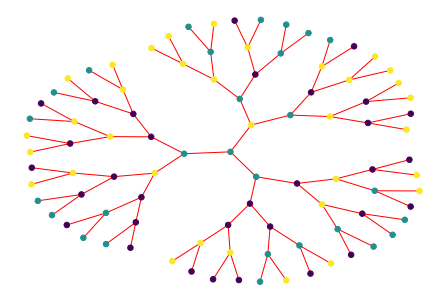

In [ ]:
color(model)

In [ ]:
result = model.evol()

p = [40, 30, 30]


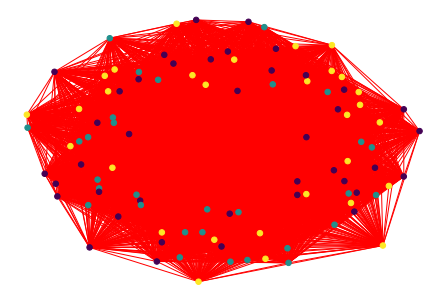

In [ ]:
color(model)

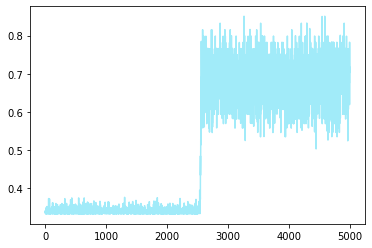

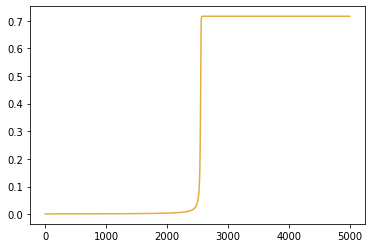

In [ ]:
#plotting(np.transpose(result[4]))
#plotting(np.transpose(result[5]))
plotting_full(result[2])
plotting_full(result[3])

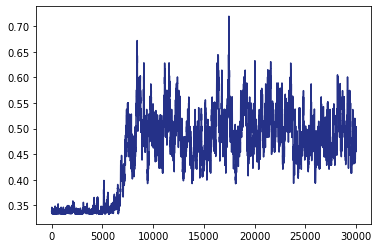

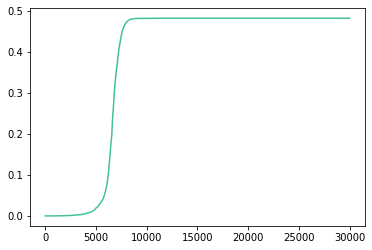

In [ ]:
plotting_full(result[-2])
plotting_full(result[-1])

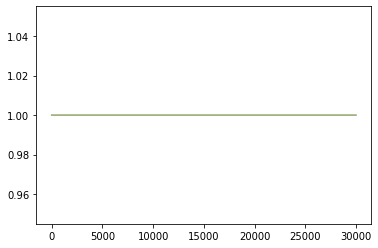

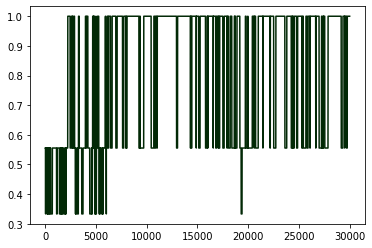

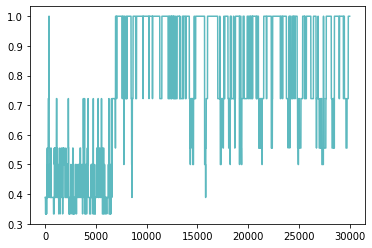

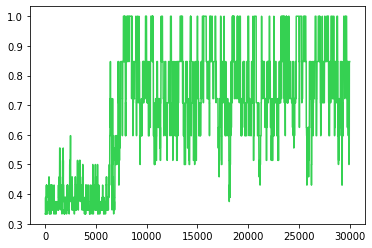

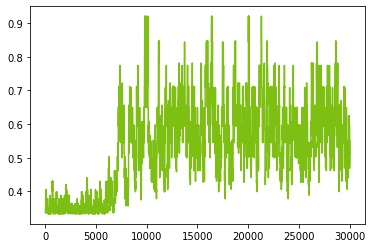

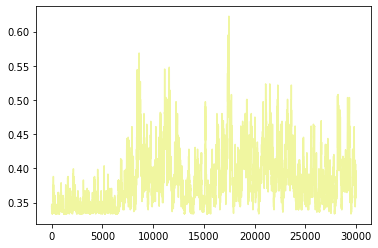

In [ ]:
for j in np.transpose(result[0]):
  plotting_full(j)


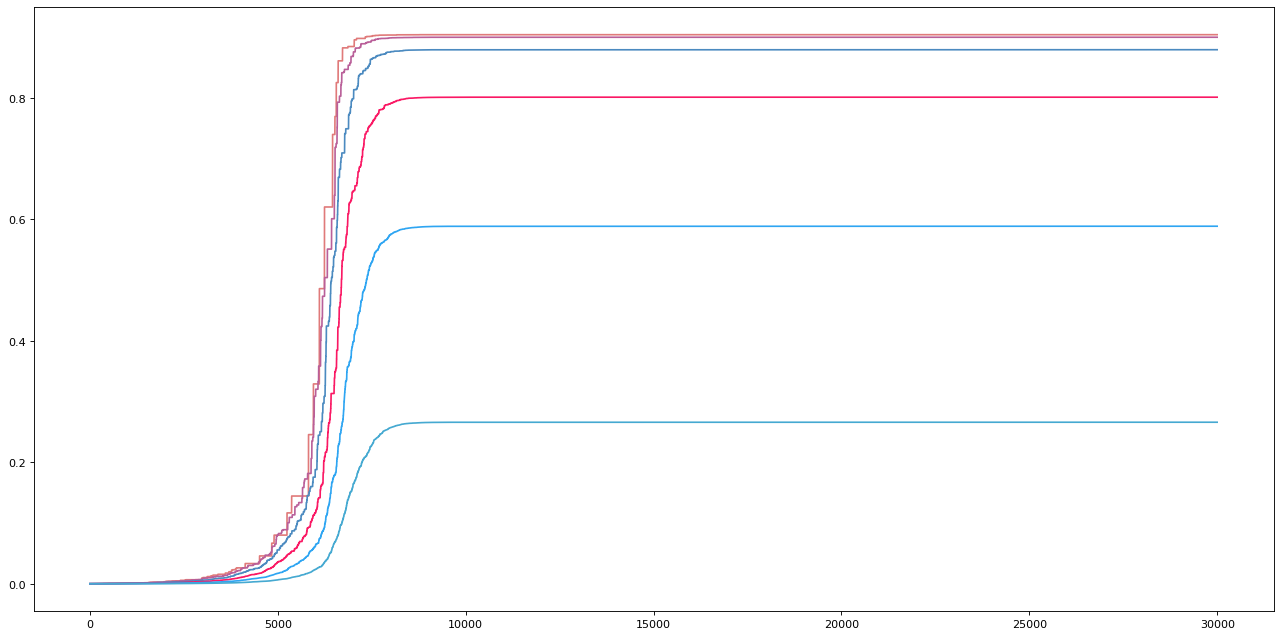

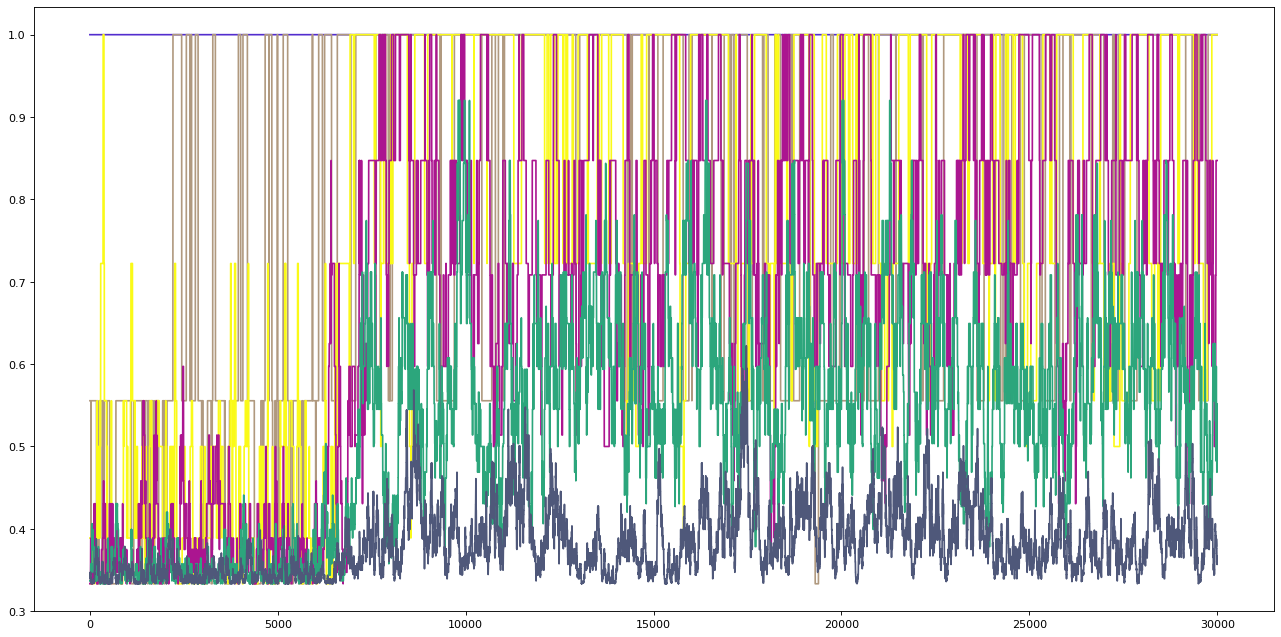

In [ ]:
plotting(np.transpose(result[1]))
plotting(np.transpose(result[0]))

In [ ]:
10/(4*np.log(2))

3.6067376022224087

In [ ]:
n = 0.3
temps = [n + i/100 for i in range(50)]
graph = graphs(parameters = [100, 3], type_of = 'full')


temp =  0.3


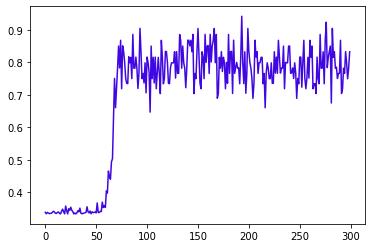

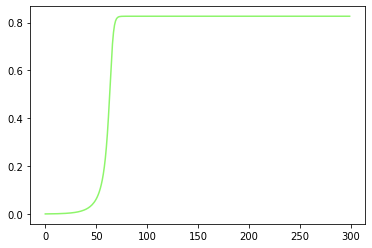

temp =  0.31


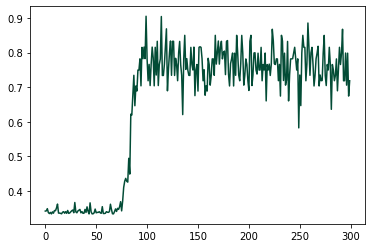

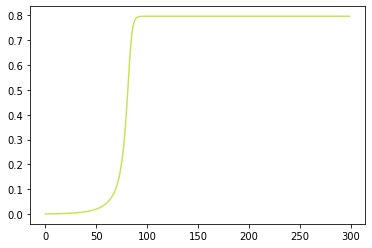

temp =  0.32


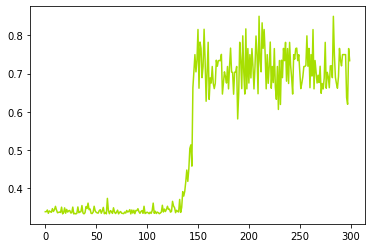

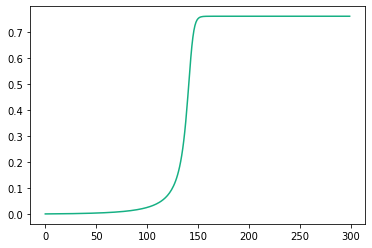

temp =  0.32999999999999996


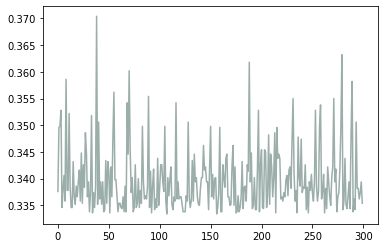

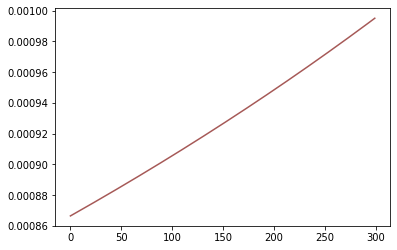

temp =  0.33999999999999997


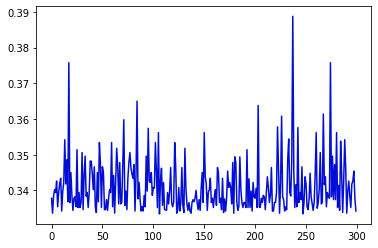

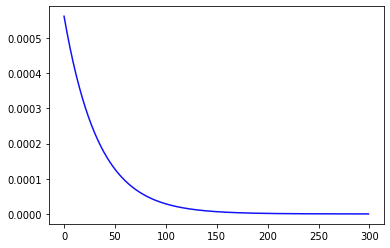

temp =  0.35


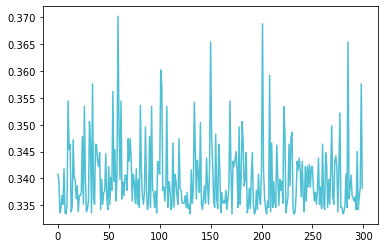

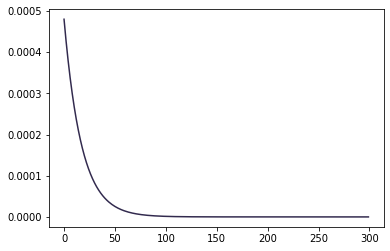

temp =  0.36


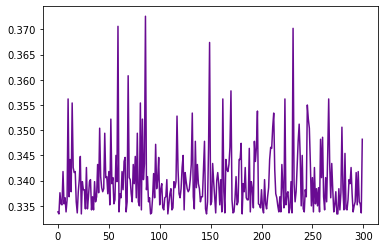

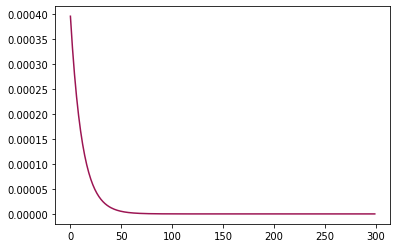

temp =  0.37


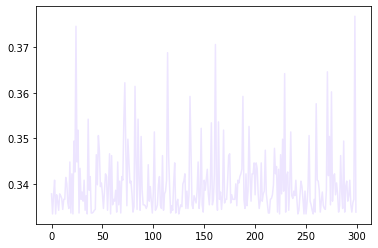

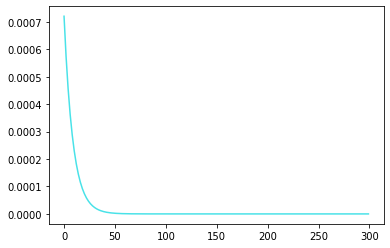

temp =  0.38


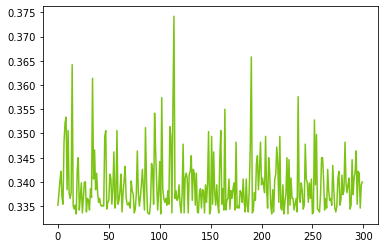

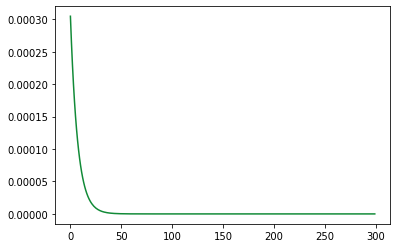

temp =  0.39


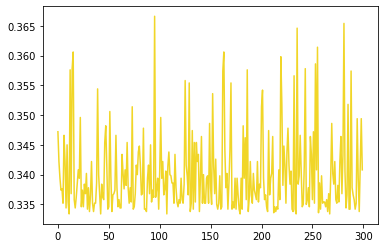

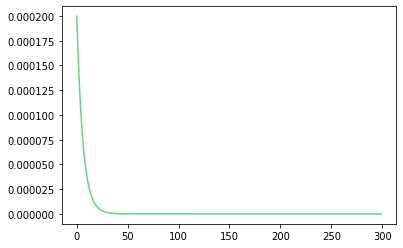

temp =  0.4


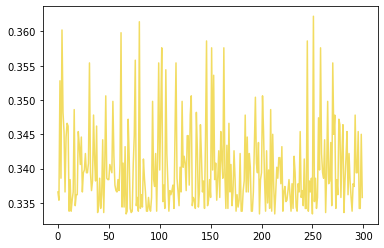

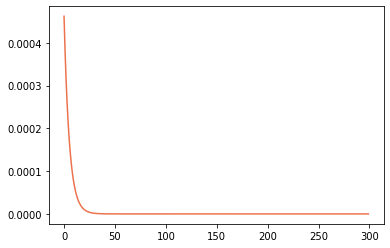

temp =  0.41


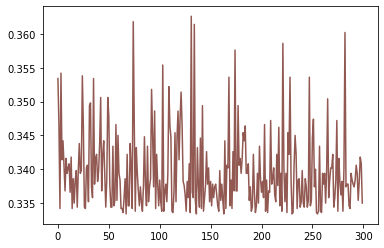

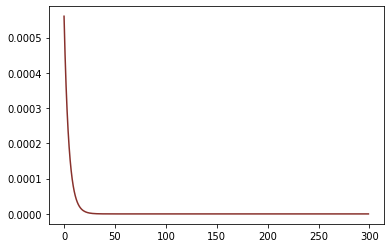

temp =  0.42


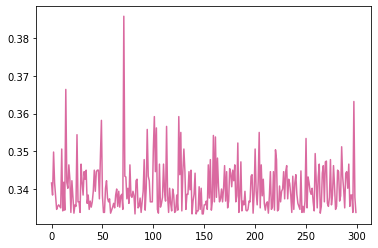

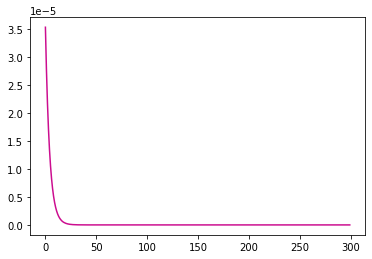

temp =  0.43


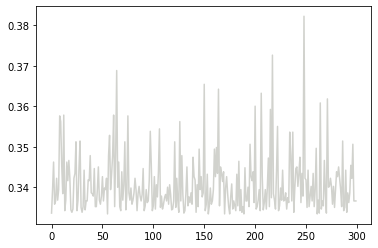

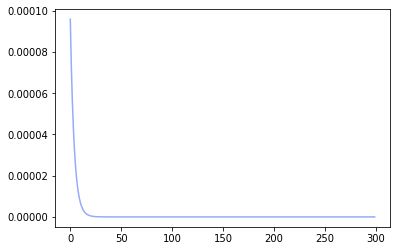

temp =  0.44


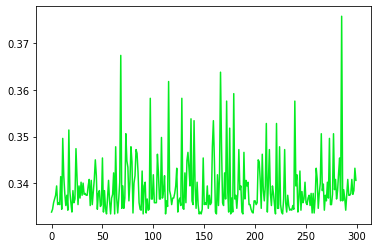

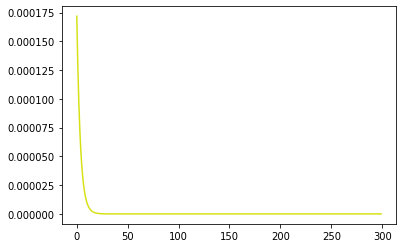

temp =  0.44999999999999996


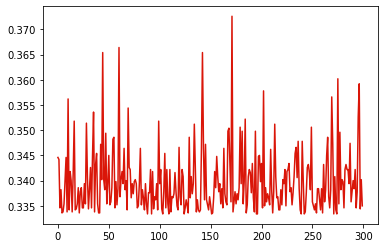

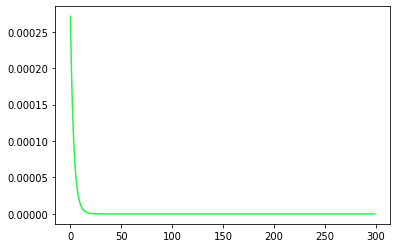

temp =  0.45999999999999996


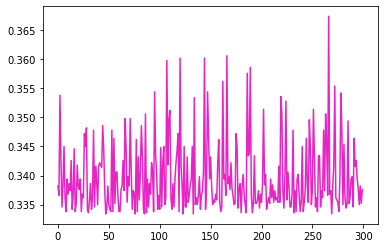

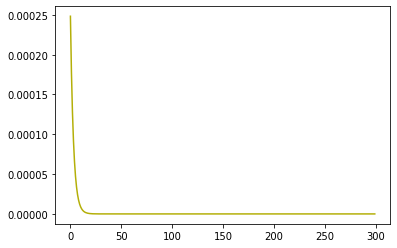

temp =  0.47


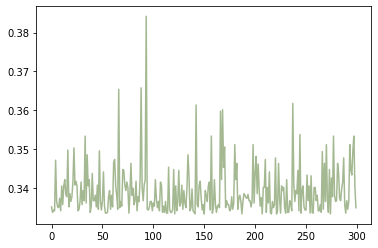

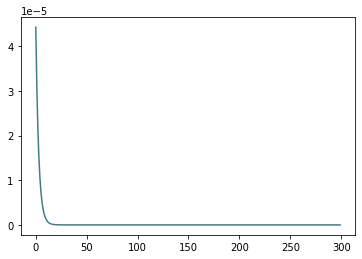

temp =  0.48


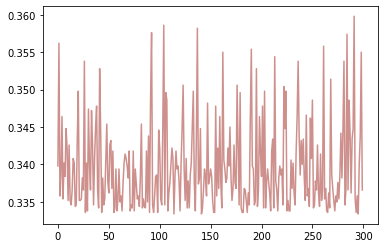

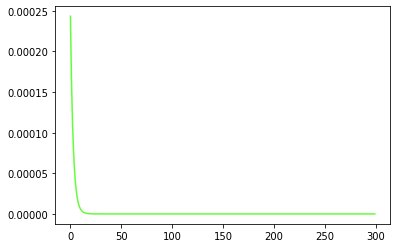

temp =  0.49


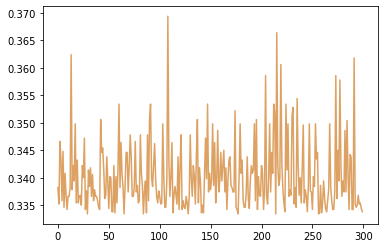

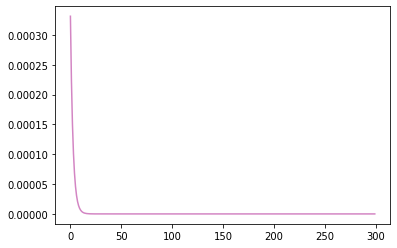

temp =  0.5


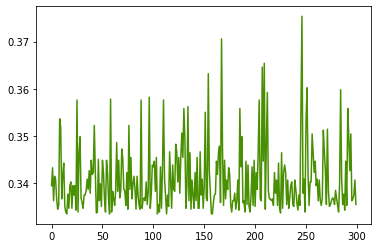

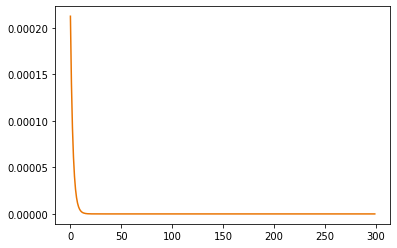

temp =  0.51


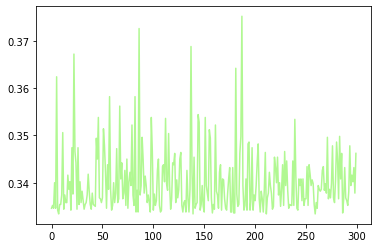

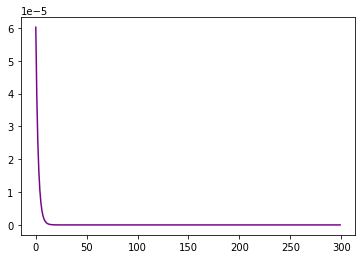

temp =  0.52


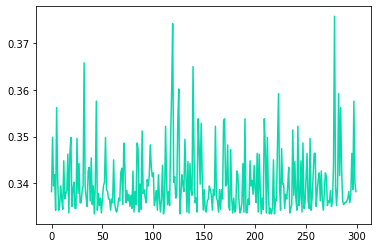

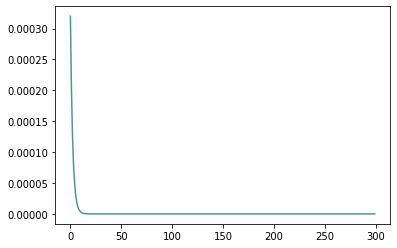

temp =  0.53


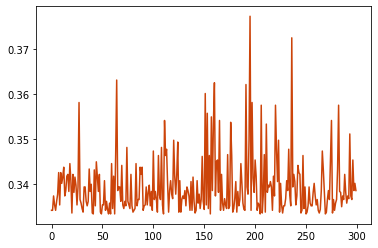

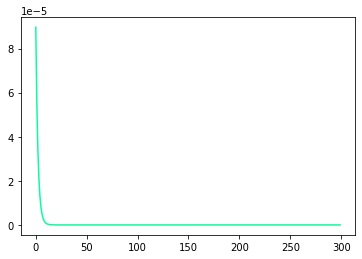

temp =  0.54


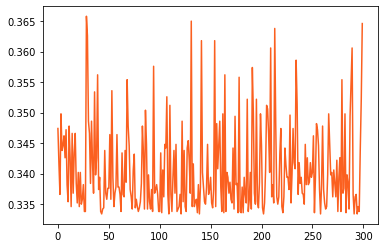

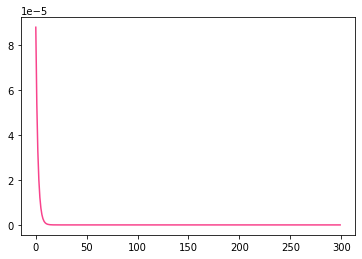

temp =  0.55


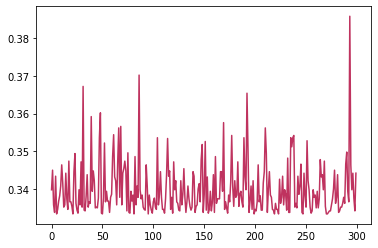

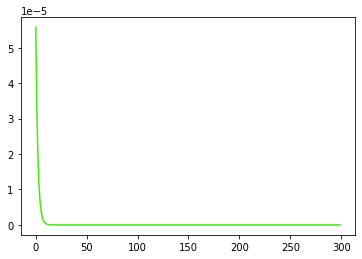

temp =  0.56


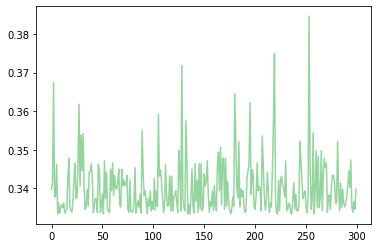

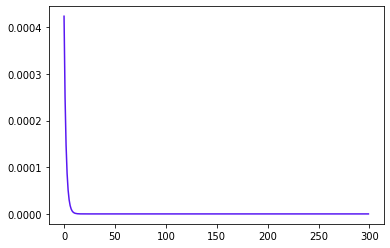

temp =  0.5700000000000001


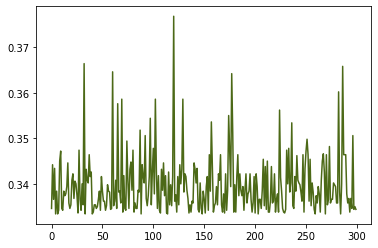

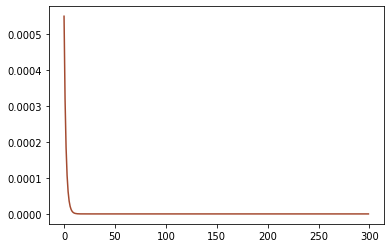

temp =  0.5800000000000001


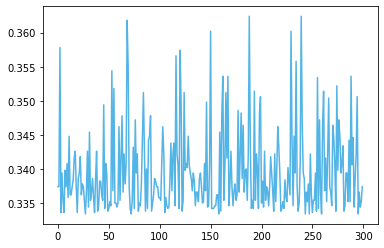

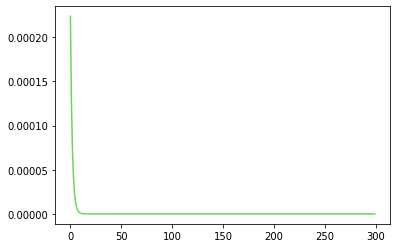

temp =  0.59


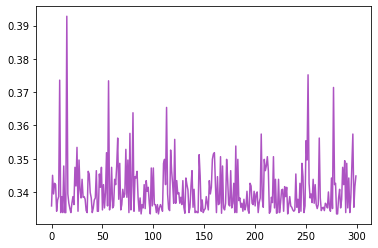

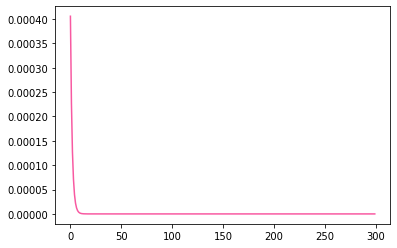

temp =  0.6


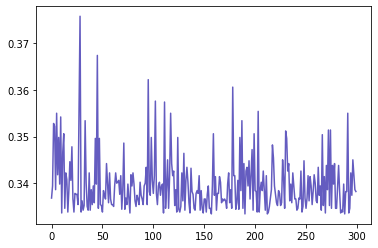

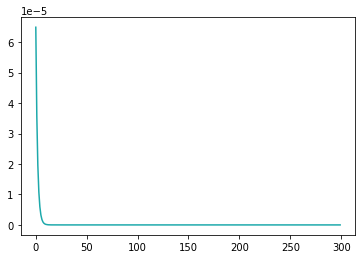

temp =  0.61


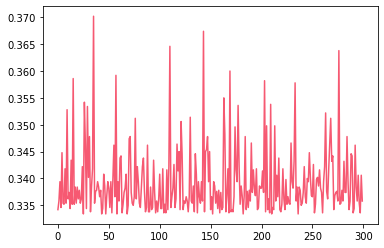

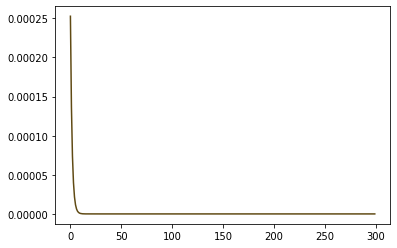

temp =  0.62


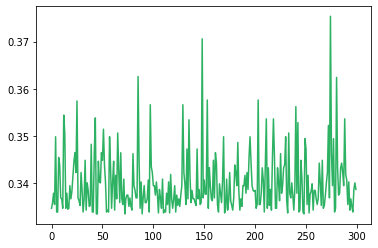

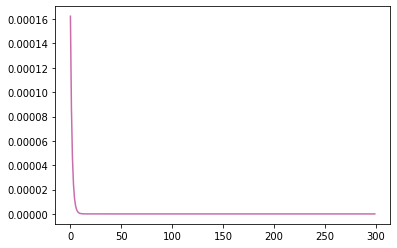

temp =  0.63


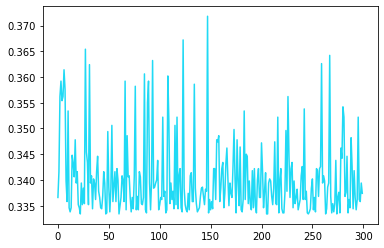

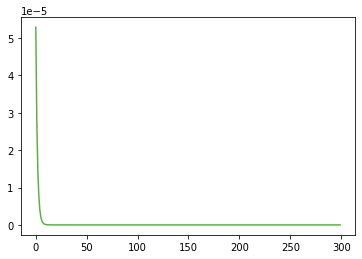

temp =  0.64


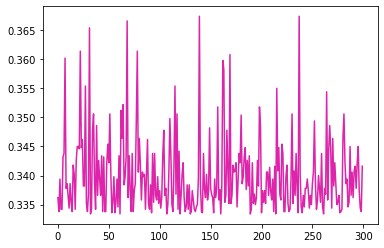

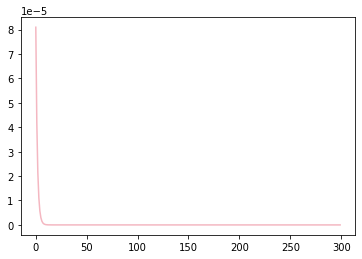

temp =  0.6499999999999999


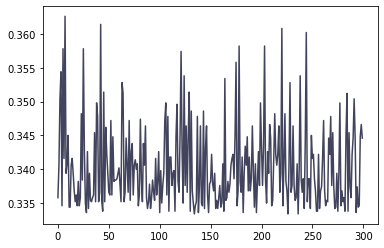

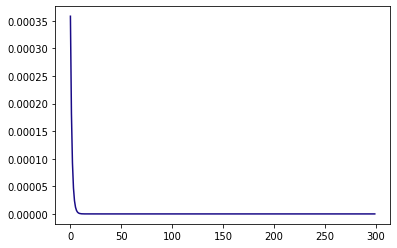

temp =  0.6599999999999999


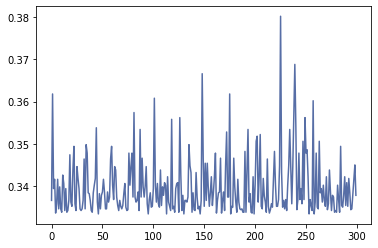

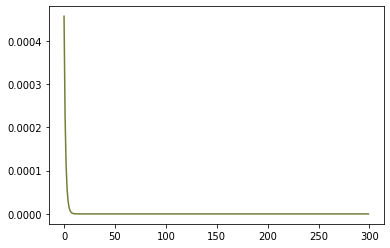

temp =  0.6699999999999999


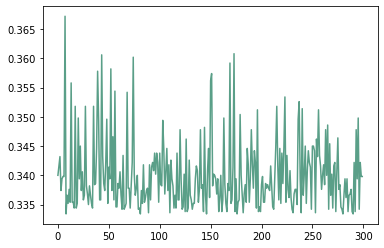

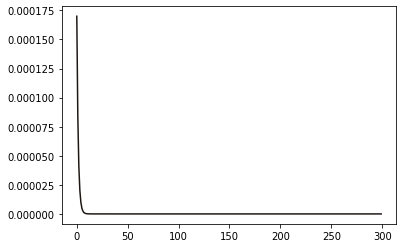

temp =  0.6799999999999999


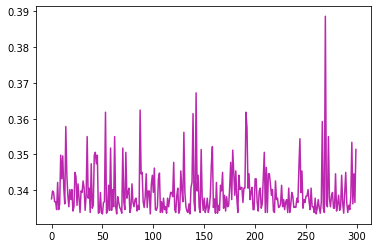

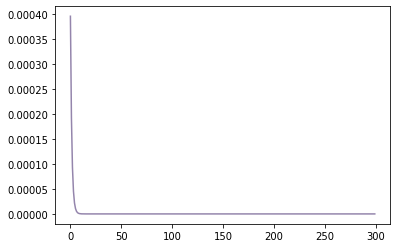

temp =  0.69


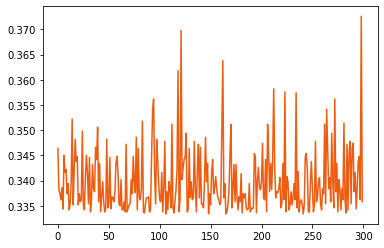

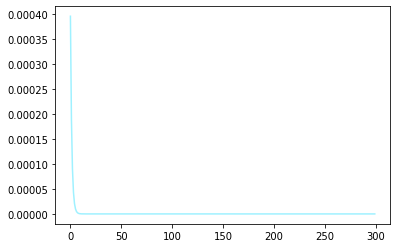

temp =  0.7


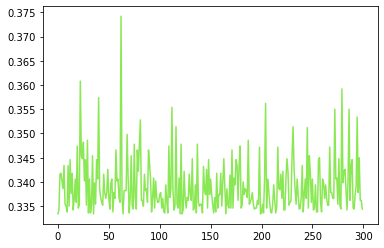

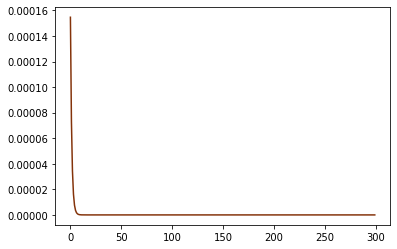

temp =  0.71


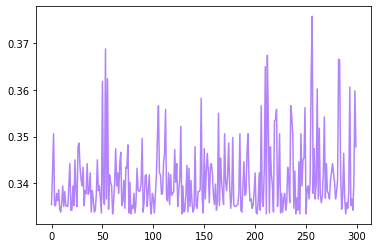

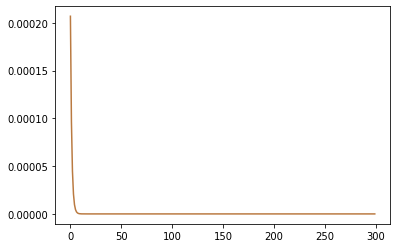

temp =  0.72


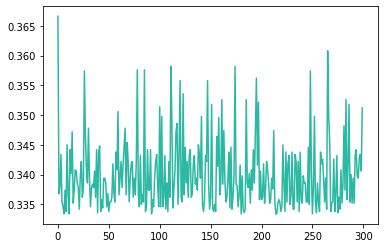

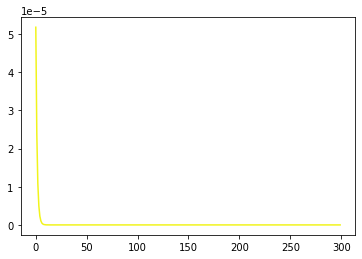

temp =  0.73


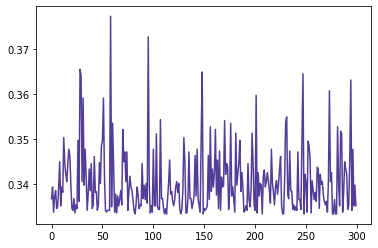

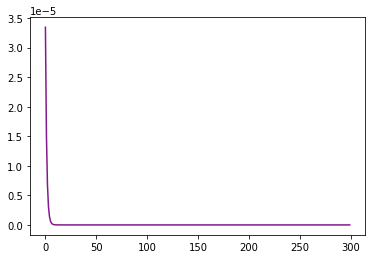

temp =  0.74


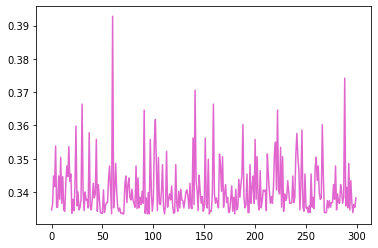

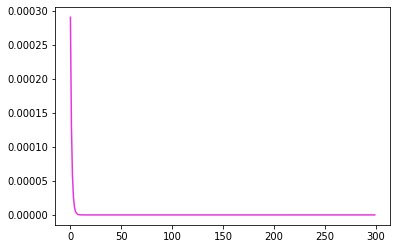

temp =  0.75


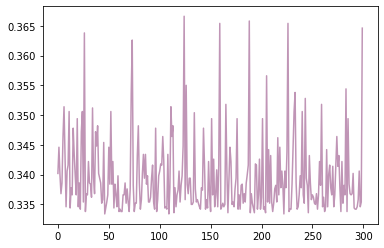

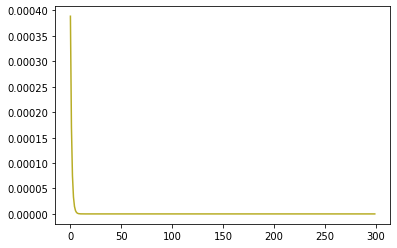

temp =  0.76


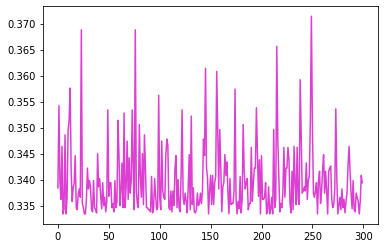

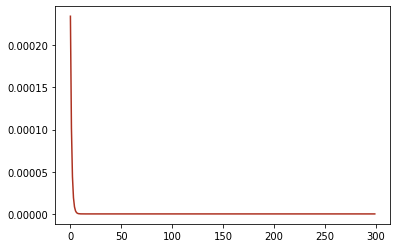

temp =  0.77


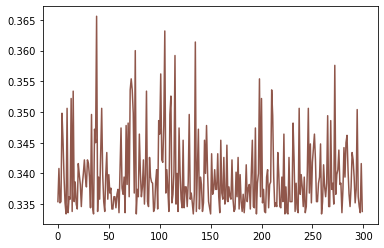

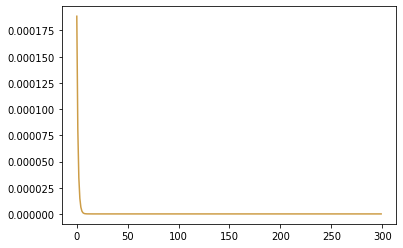

temp =  0.78


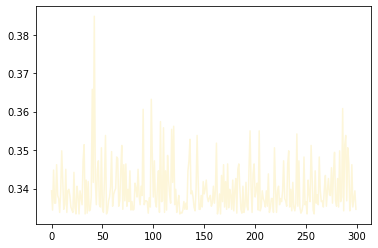

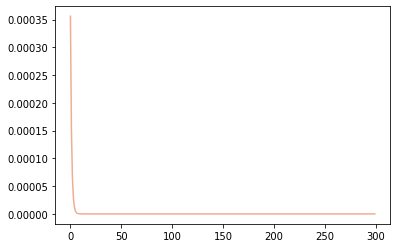

temp =  0.79


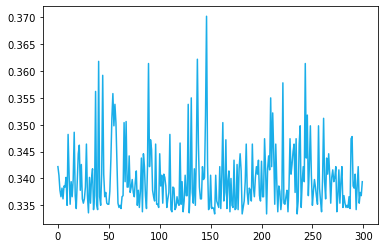

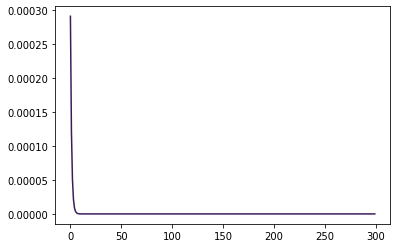

In [ ]:
t_mass = []
h_mass = []
for j in temps:
  print('temp = ', j)
  model = potts(graph = graph, J = 1, gamma = j, Q = 3, t = 300, synch = True)
  result = model.evol()
  t_mass.append(result[3][-1])
  h_mass.append(np.mean(result[2][-10:-1]))
#  print(result[2])
  plotting_full(result[2])
  plotting_full(result[3])

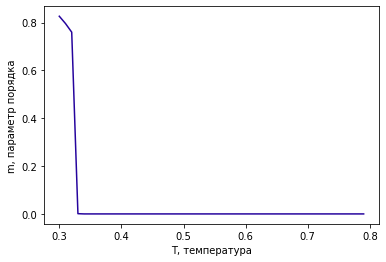

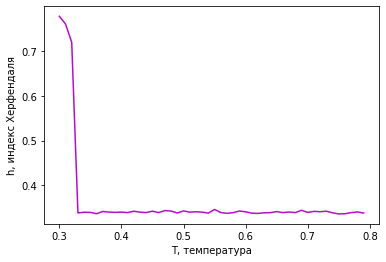

In [ ]:
plotting_full_und(t_mass, temps, 'T, температура', 'm, параметр порядка')
plotting_full_und(h_mass, temps, 'T, температура', 'h, индекс Херфендаля',)

In [ ]:
n = 0.1
temps = [n + 0.05*i for i in range(10)]
num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
temps

[0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35,
 0.4,
 0.45000000000000007,
 0.5,
 0.55]

In [ ]:
dif_graps_t = []
dif_graps_h = []
for gr in num:
  graph = graphs(parameters = [10*gr, 3], type_of = 'full')
  t_mass = []
  h_mass = []
  for j in temps:
#    print('temp = ', j)
    model = potts(graph = graph, J = 1, gamma = j, Q = 3, t = 5000, synch = False)
    result = model.evol()
    t_mass.append(result[3][-1])
    h_mass.append(np.mean(result[2][-100:-1]))
#   print(result[2])
#    plotting_full(result[2])
#    plotting_full(result[3])
  dif_graps_t.append(t_mass)
  dif_graps_h.append(h_mass)

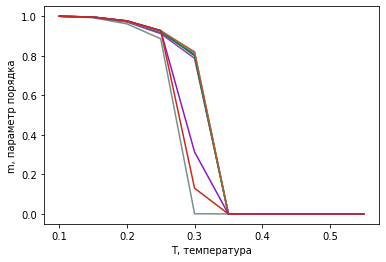

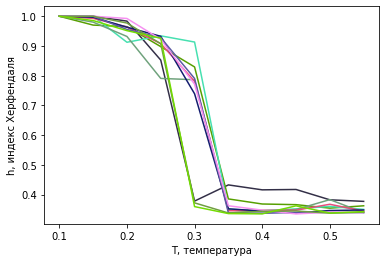

In [ ]:
plotting(dif_graps_t, temps, 'T, температура', 'm, параметр порядка')
plotting(dif_graps_h, temps, 'T, температура', 'h, индекс Херфендаля')

In [ ]:
N = 5
a = np.ones((N, N))
b = np.eye(N)
b

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
c = a - b
print(c[1])
print(np.nonzero(c[1]))

[1. 0. 1. 1. 1.]
(array([0, 2, 3, 4]),)


In [ ]:
n = 0.01
temps = [n + i/100 for i in range(20)]
graph = graphs(parameters = [5, 3], type_of = 'bethe')

temp =  0.01
p = [26, 26, 42]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


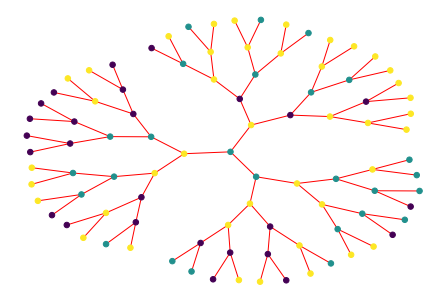

p = [94]


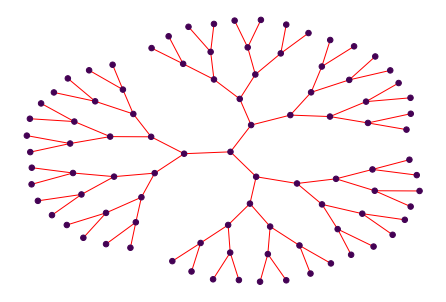

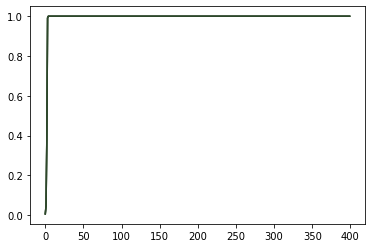

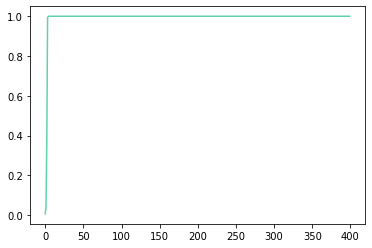

temp =  0.02
p = [32, 31, 31]


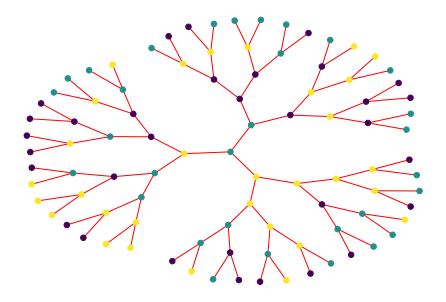

p = [94]


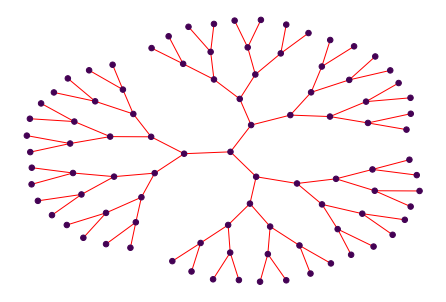

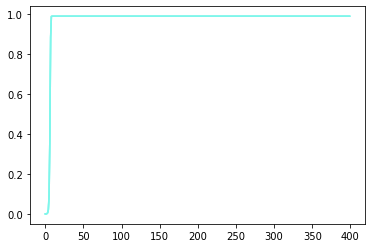

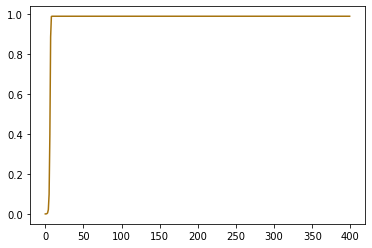

temp =  0.03
p = [40, 27, 27]


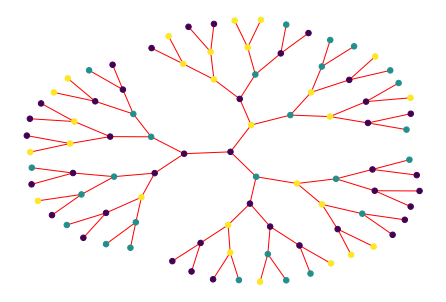

p = [91, 2, 1]


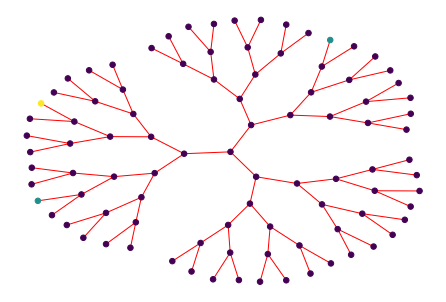

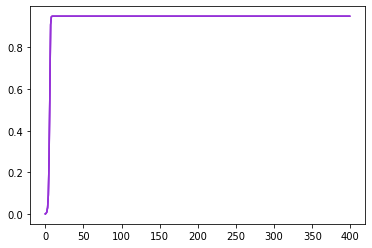

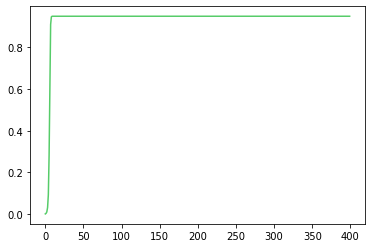

temp =  0.04
p = [38, 29, 27]


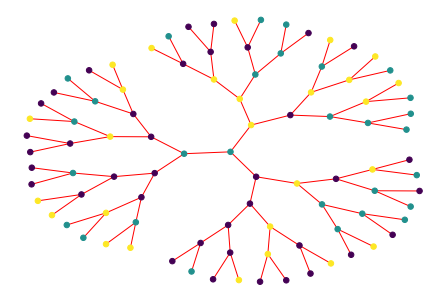

p = [87, 3, 4]


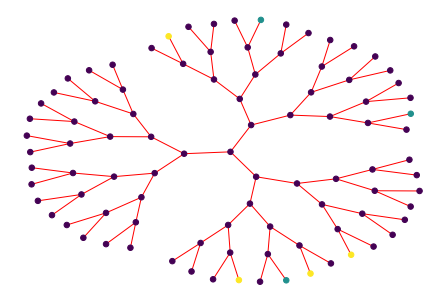

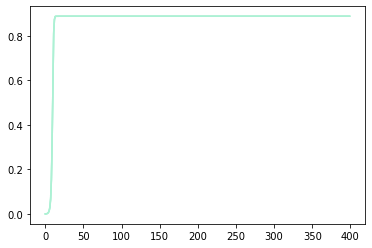

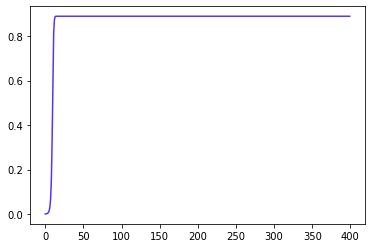

temp =  0.05
p = [31, 39, 24]


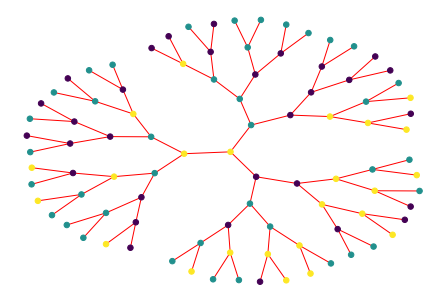

p = [83, 6, 5]


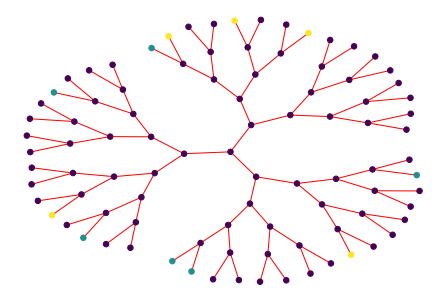

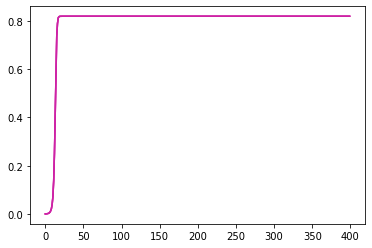

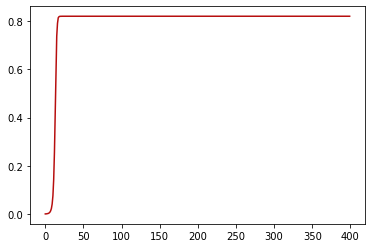

temp =  0.060000000000000005
p = [30, 33, 31]


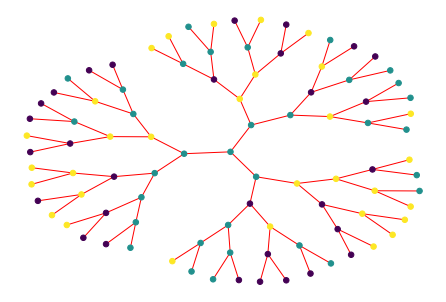

p = [80, 5, 9]


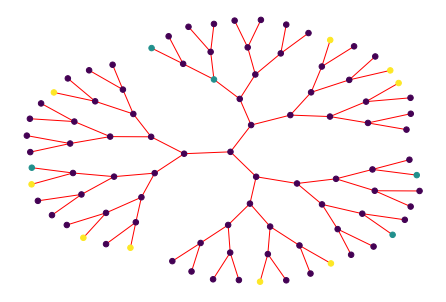

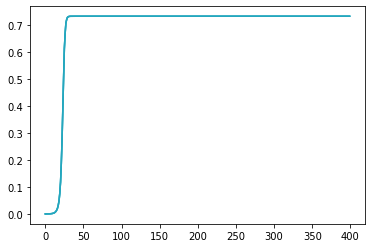

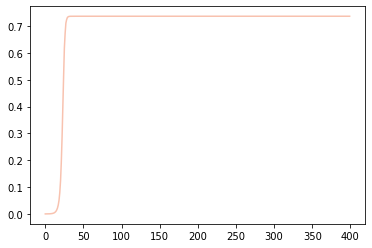

temp =  0.06999999999999999
p = [32, 37, 25]


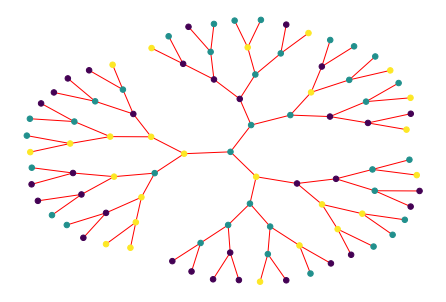

p = [67, 16, 11]


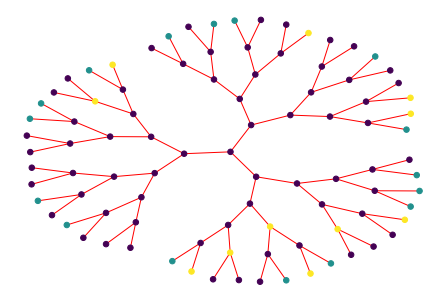

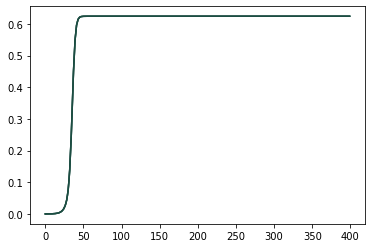

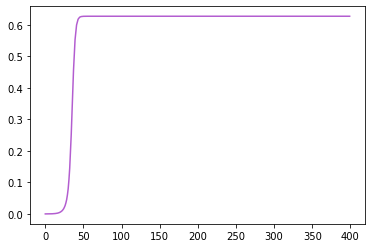

temp =  0.08
p = [32, 32, 30]


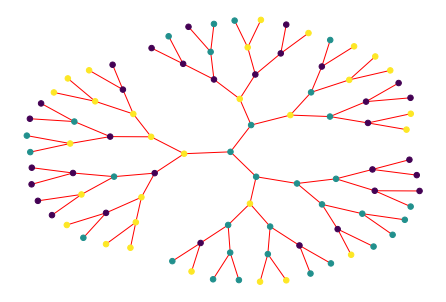

p = [55, 22, 17]


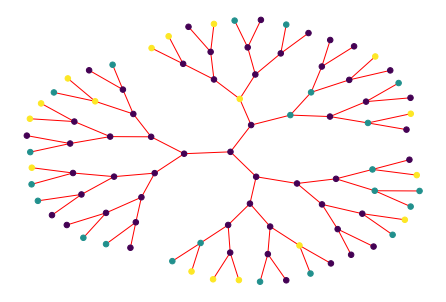

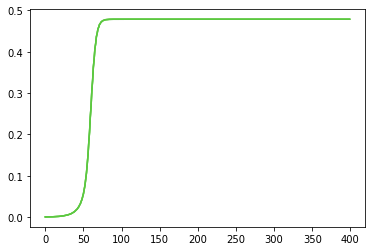

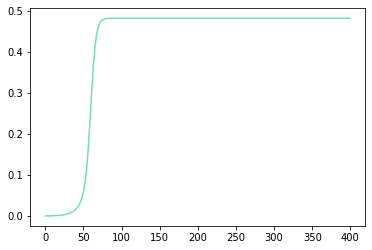

temp =  0.09
p = [37, 30, 27]


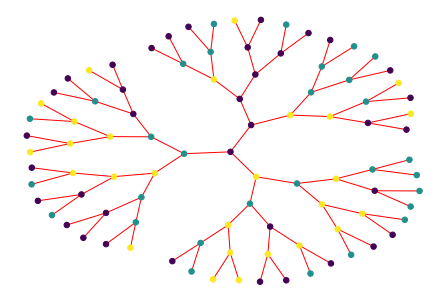

p = [21, 37, 36]


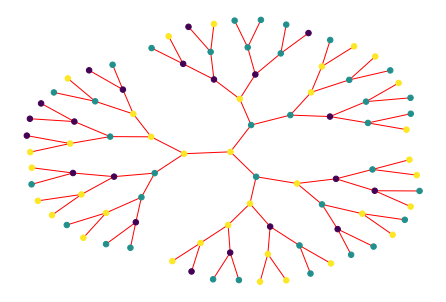

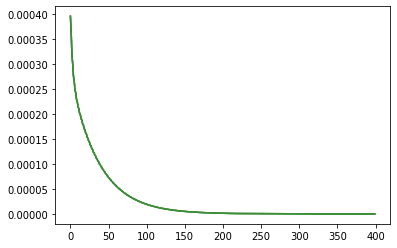

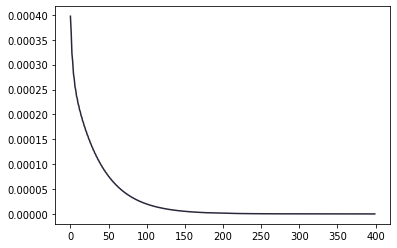

temp =  0.09999999999999999
p = [39, 30, 25]


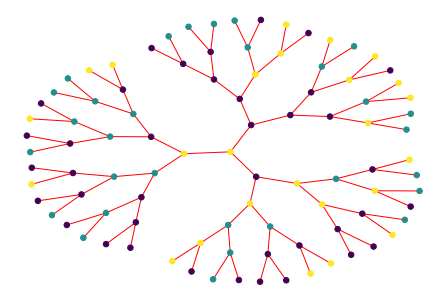

p = [36, 35, 23]


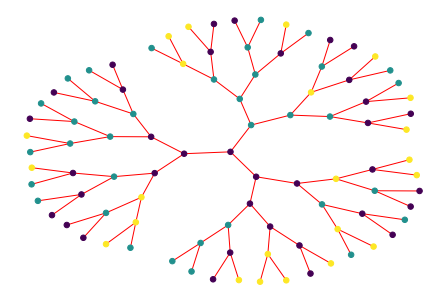

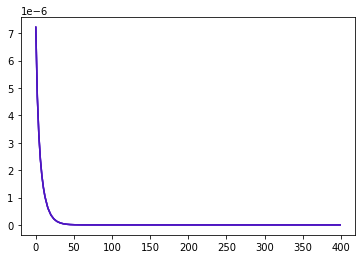

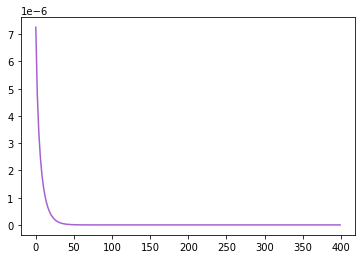

temp =  0.11
p = [31, 27, 36]


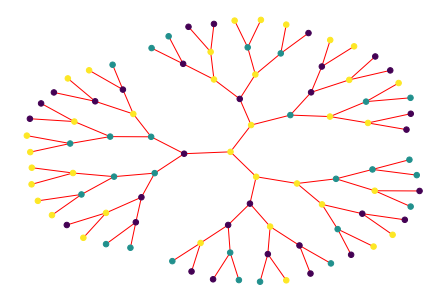

p = [25, 37, 32]


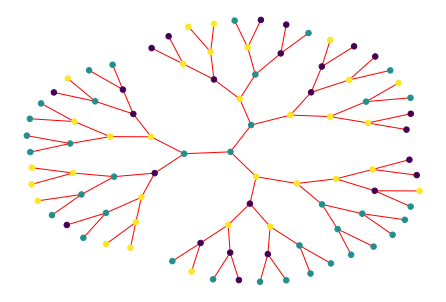

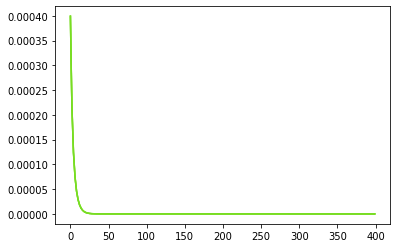

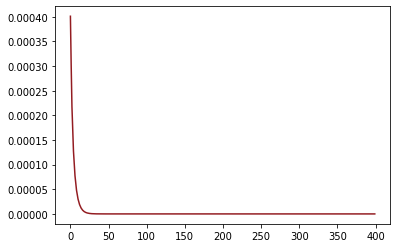

temp =  0.12
p = [28, 27, 39]


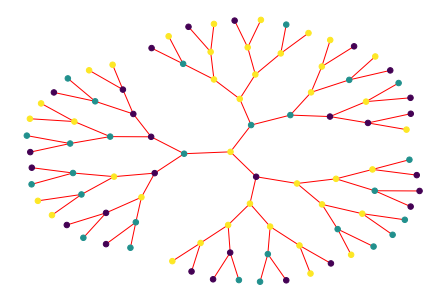

p = [33, 29, 32]


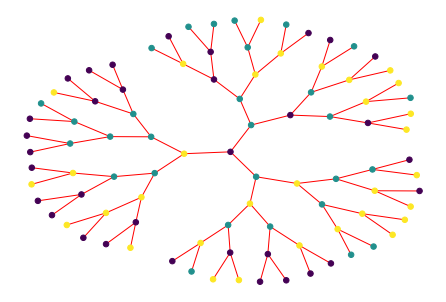

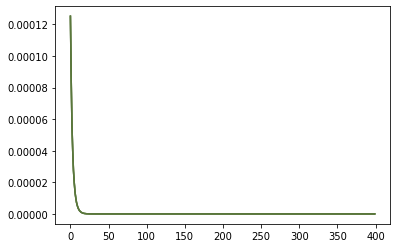

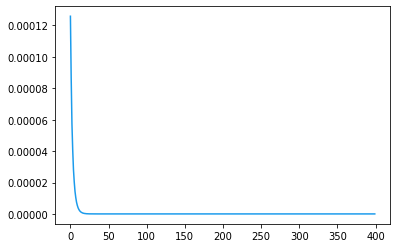

temp =  0.13
p = [21, 37, 36]


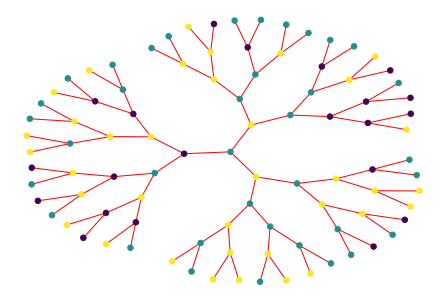

p = [31, 30, 33]


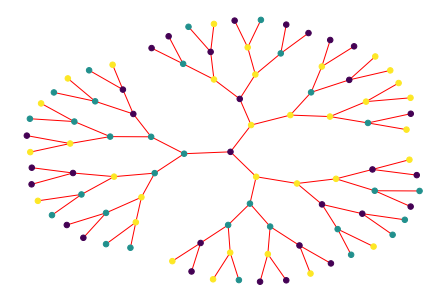

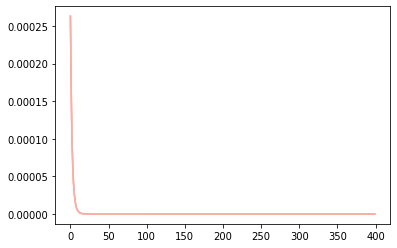

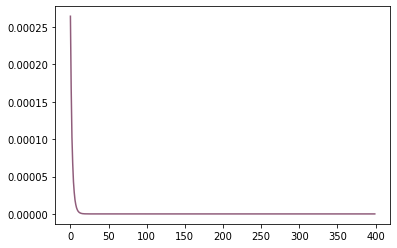

temp =  0.14
p = [23, 35, 36]


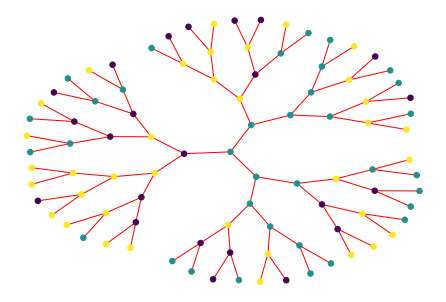

p = [32, 31, 31]


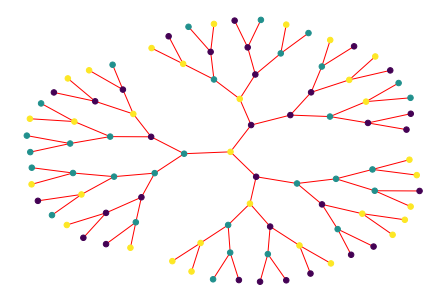

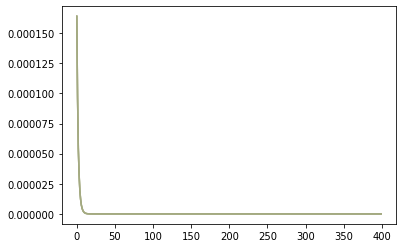

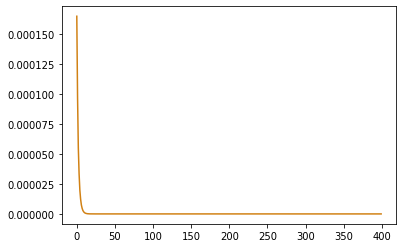

temp =  0.15000000000000002
p = [36, 28, 30]


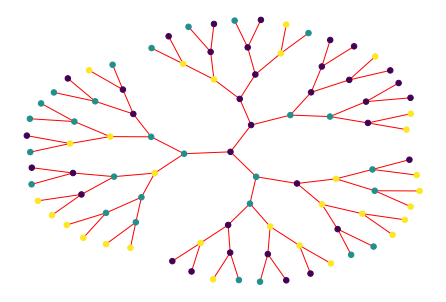

p = [31, 40, 23]


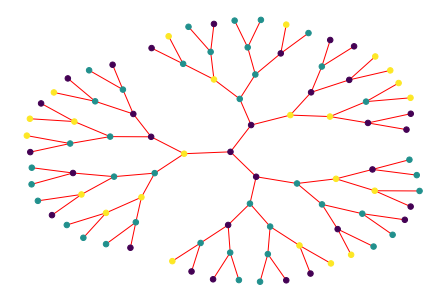

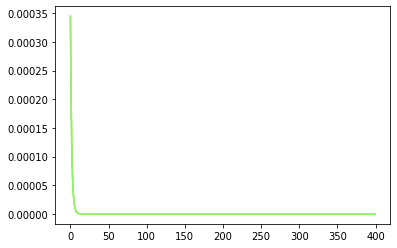

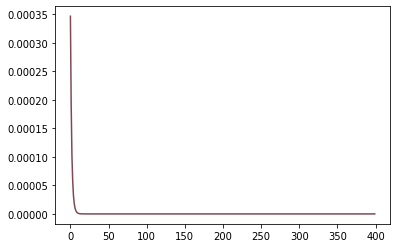

temp =  0.16
p = [36, 31, 27]


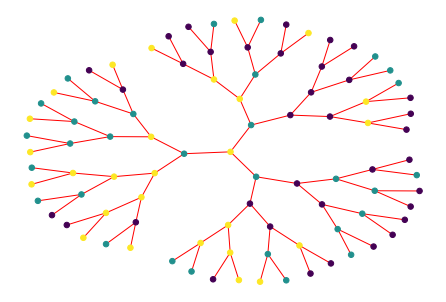

p = [28, 33, 33]


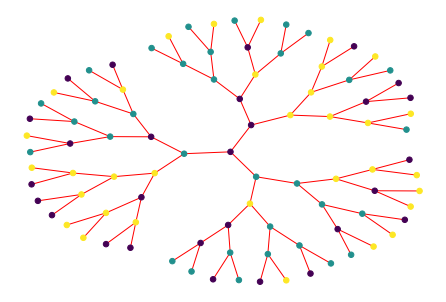

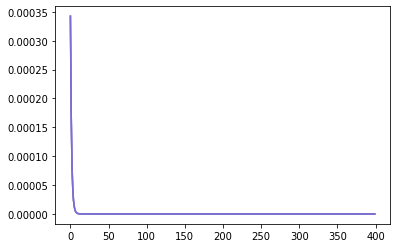

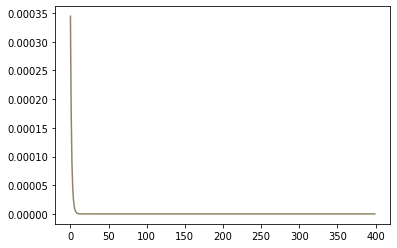

temp =  0.17
p = [43, 26, 25]


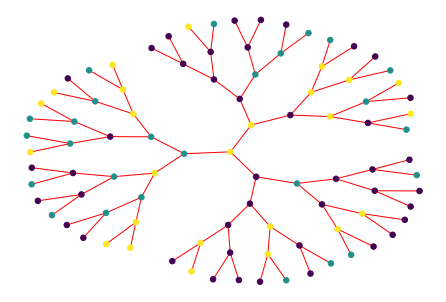

p = [35, 27, 32]


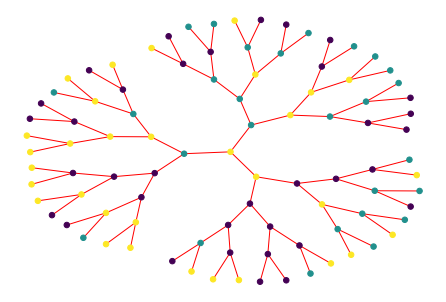

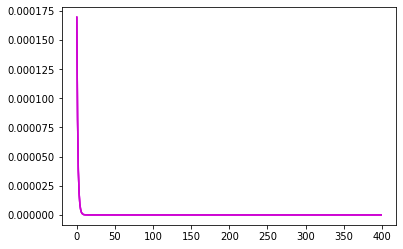

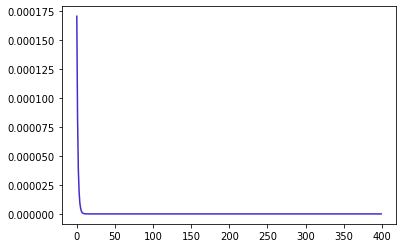

temp =  0.18000000000000002
p = [33, 29, 32]


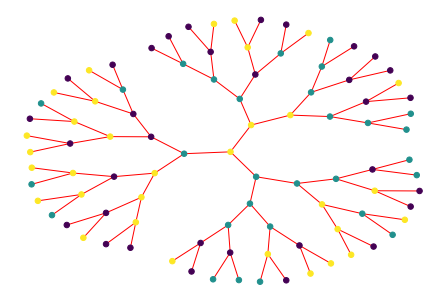

p = [34, 30, 30]


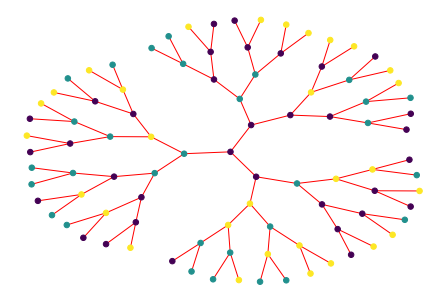

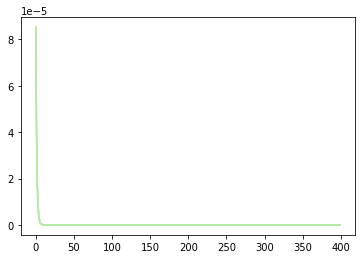

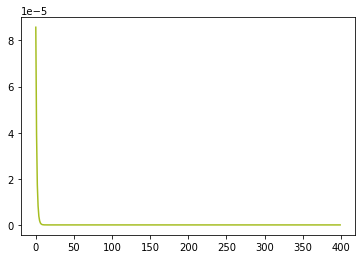

temp =  0.19
p = [27, 27, 40]


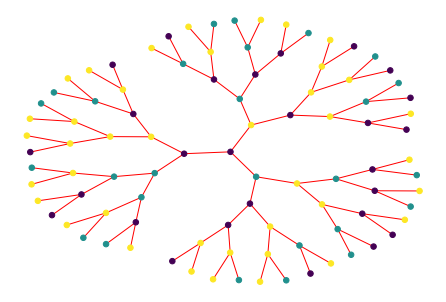

p = [32, 32, 30]


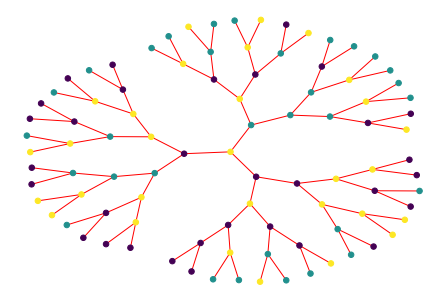

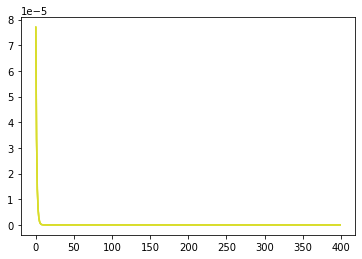

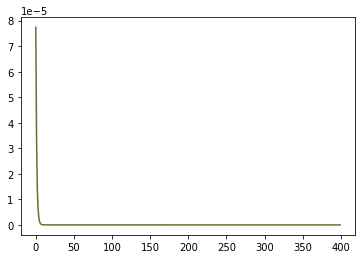

temp =  0.2
p = [31, 30, 33]


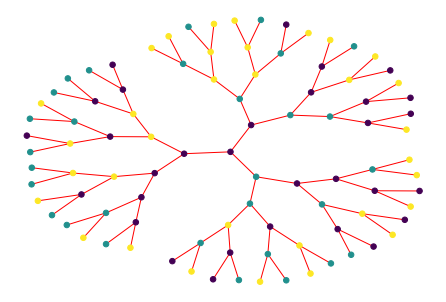

p = [33, 28, 33]


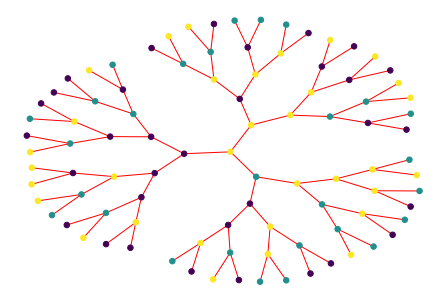

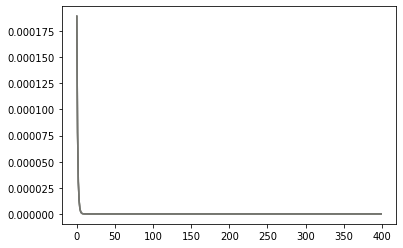

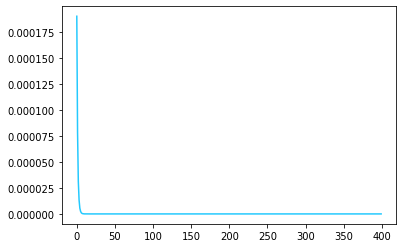

In [ ]:
t_mass = []
h_mass = []
h_mass_full = []
t_mass_full = []
for j in temps:
  print('temp = ', j)
  model = potts(graph = graph, J = 0.1, gamma = j, Q = 3, t = 400, synch = True)
  color(model)
  result = model.evol()
  color(model)
  t_mass.append(result[1][-1])
  h_mass.append(np.mean(result[0][-50:-1], axis = 0))
  h_mass_full.append(np.mean(result[2][-50:-1]))
  t_mass_full.append(np.mean(result[3][-50:-1]))
  plotting_full(result[-2])
  plotting_full(result[3])


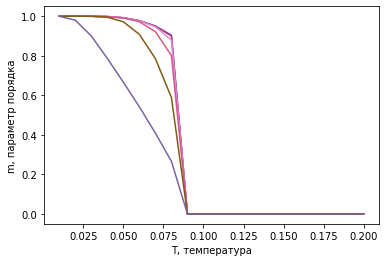

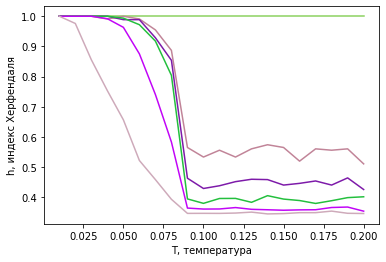

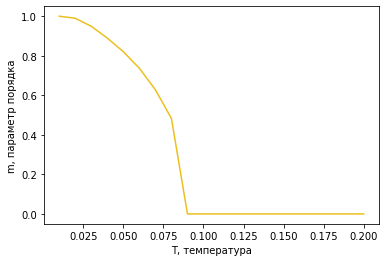

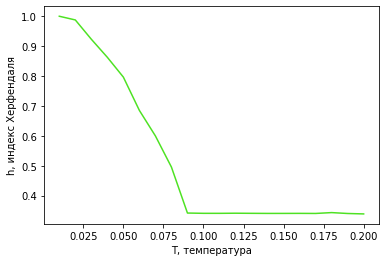

In [ ]:
plotting(np.transpose(t_mass), temps, 'T, температура', 'm, параметр порядка')
plotting(np.transpose(h_mass), temps, 'T, температура', 'h, индекс Херфендаля')
plotting_full_und(t_mass_full, temps, 'T, температура', 'm, параметр порядка')
plotting_full_und(h_mass_full, temps, 'T, температура', 'h, индекс Херфендаля',)

In [ ]:
n = 0.01
temps = [n + i/100 for i in range(20)]
graph = graphs(parameters = [5, 3], type_of = 'bethe')

In [ ]:
zzzz = []
for j in gr:
  t_mass = []
  h_mass = []
  h_mass_full = []
  t_mass_full = []
  for j in temps:
    print('temp = ', j)
    model = potts(graph = graph, J = 0.1, gamma = j, Q = 3, t = 400, synch = True)
    result = model.evol()
    t_mass.append(result[1][-1])
    h_mass.append(np.mean(result[0][-50:-1], axis = 0))
    h_mass_full.append(np.mean(result[2][-50:-1]))
    t_mass_full.append(np.mean(result[3][-50:-1]))
    plotting_full(result[-2])
    plotting_full(result[3])

In [ ]:
mass = [0,1,1,2,1]
spin = 1
k = (np.in1d(mass, spin).sum()**2)/(len(mass))
k

1.8

In [ ]:
mass = np.array([0,1,1,2,1])
mass + 1

array([1, 2, 2, 3, 2])

In [ ]:
np.mean(result[0], axis = 0)

array([1.        , 0.82095556, 0.78057778, 0.68887361, 0.53288437,
       0.38278929])

In [ ]:
n = 0.01
temps = [n + i/100 for i in range(20)]
graph = graphs(parameters = [5, 3], type_of = 'bethe_closure')

temp =  0.01


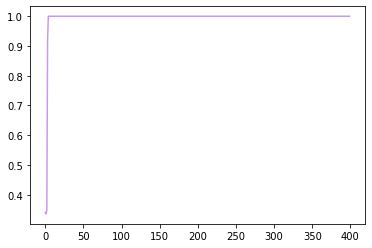

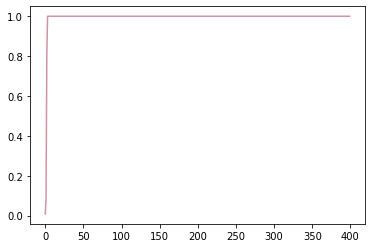

temp =  0.02


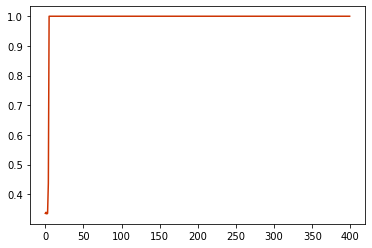

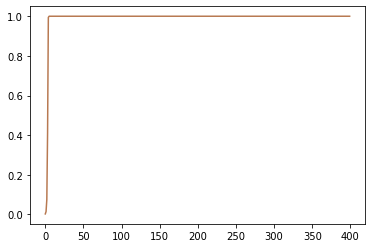

temp =  0.03


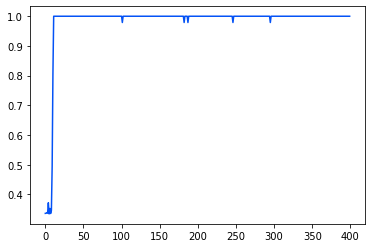

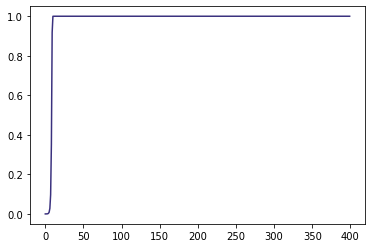

temp =  0.04


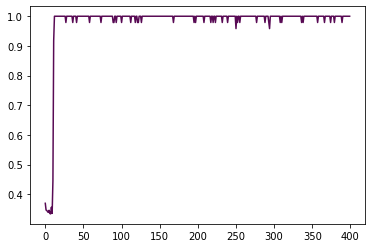

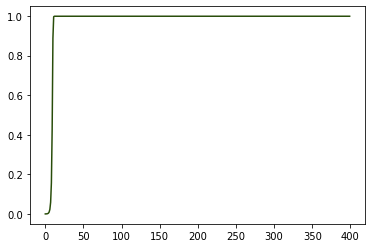

temp =  0.05


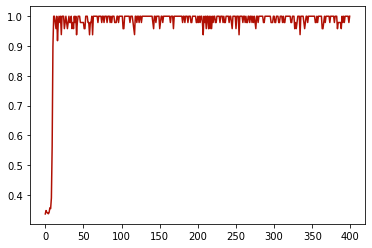

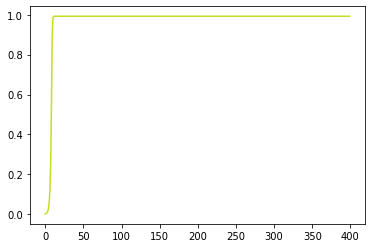

temp =  0.060000000000000005


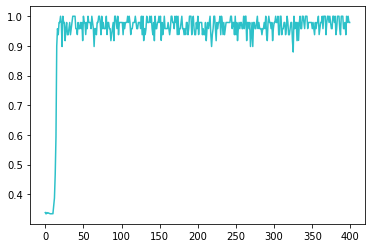

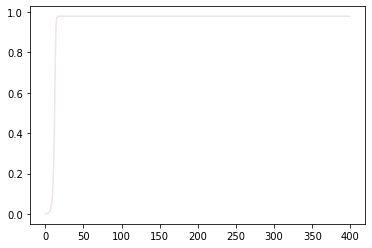

temp =  0.06999999999999999


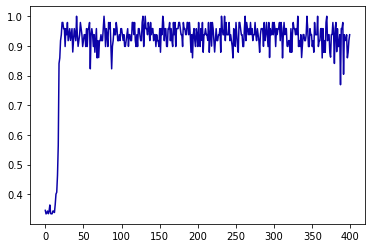

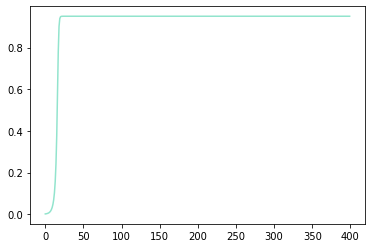

temp =  0.08


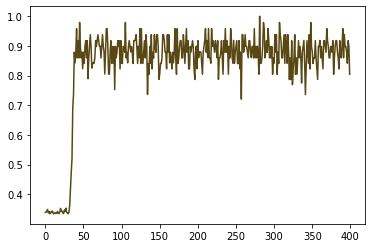

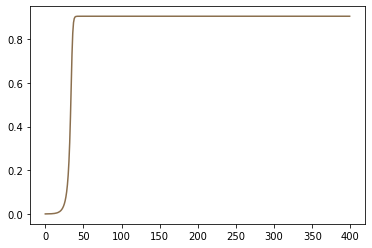

temp =  0.09


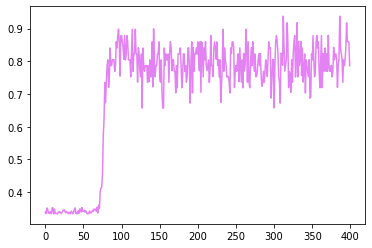

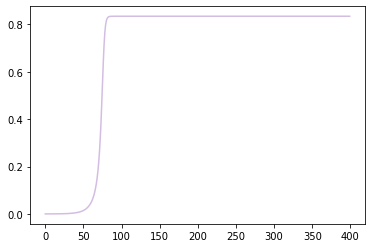

temp =  0.09999999999999999


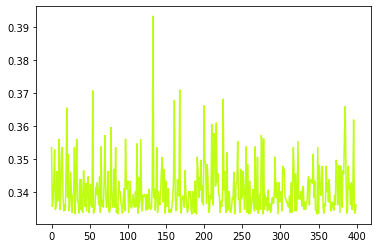

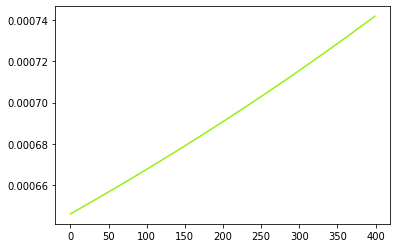

temp =  0.11


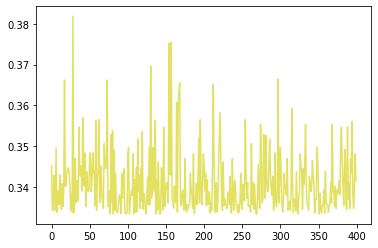

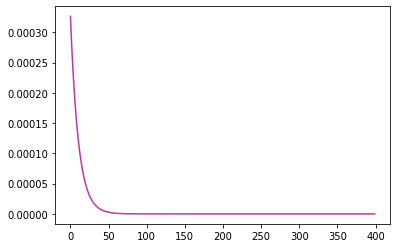

temp =  0.12


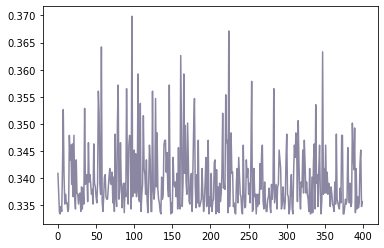

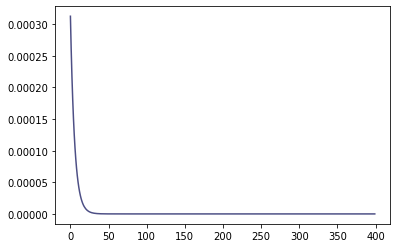

temp =  0.13


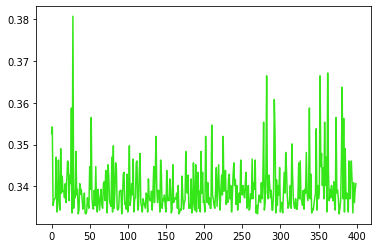

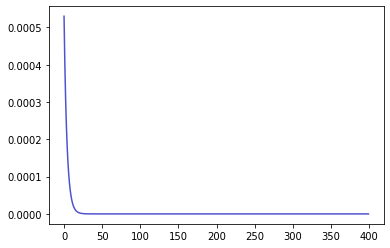

temp =  0.14


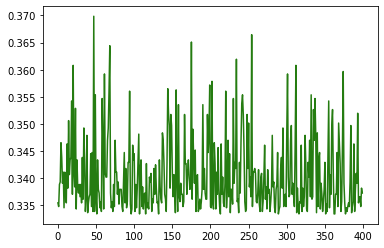

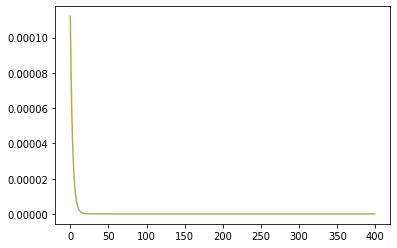

temp =  0.15000000000000002


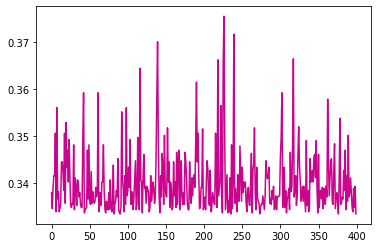

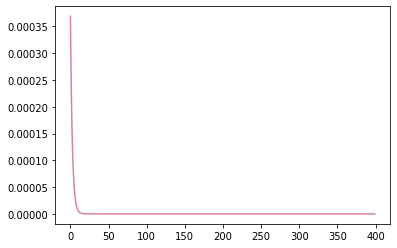

temp =  0.16


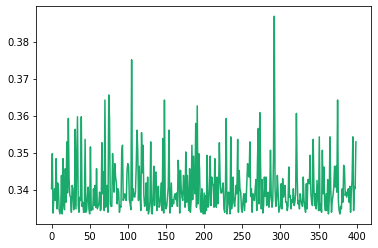

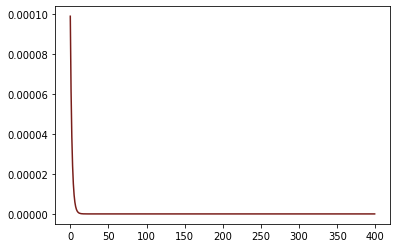

temp =  0.17


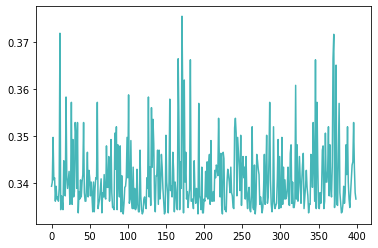

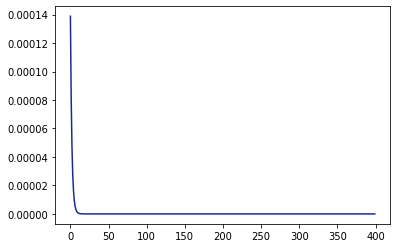

temp =  0.18000000000000002


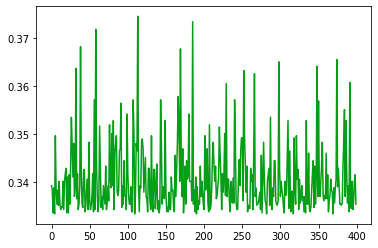

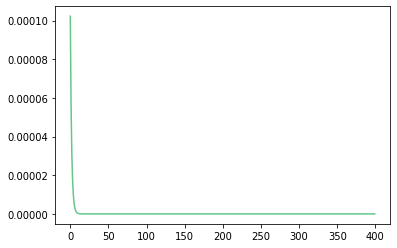

temp =  0.19


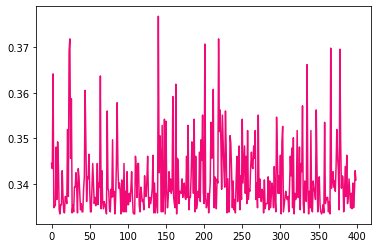

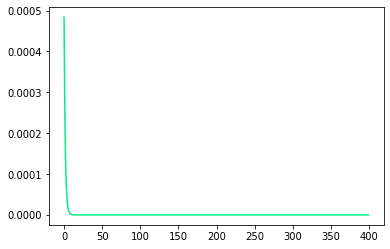

temp =  0.2


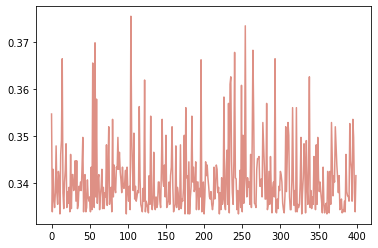

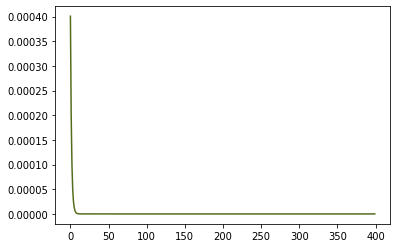

In [ ]:
t_mass = []
h_mass = []
h_mass_full = []
t_mass_full = []
for j in temps:
  print('temp = ', j)
  model = potts(graph = graph, J = 0.1, gamma = j, Q = 3, t = 400, synch = True)
  result = model.evol()
  t_mass.append(result[1][-1])
  h_mass.append(np.mean(result[0][-50:-1], axis = 0))
  h_mass_full.append(np.mean(result[2][-50:-1]))
  t_mass_full.append(np.mean(result[3][-50:-1]))
  plotting_full(result[-2])
  plotting_full(result[3])

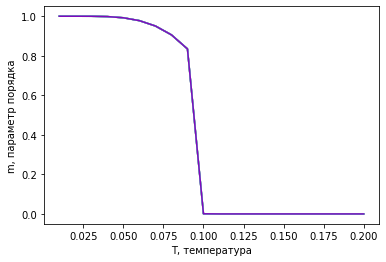

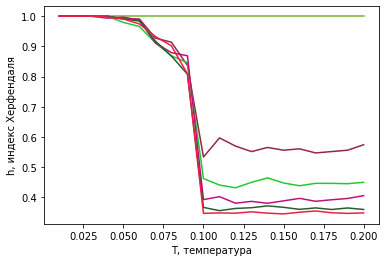

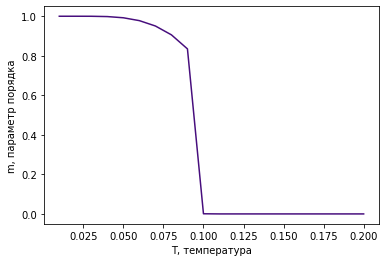

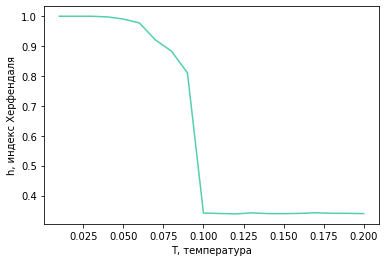

In [ ]:
plotting(np.transpose(t_mass), temps, 'T, температура', 'm, параметр порядка')
plotting(np.transpose(h_mass), temps, 'T, температура', 'h, индекс Херфендаля')
plotting_full_und(t_mass_full, temps, 'T, температура', 'm, параметр порядка')
plotting_full_und(h_mass_full, temps, 'T, температура', 'h, индекс Херфендаля',)

In [ ]:
n = 0.01
#temps = [n + i/100 for i in range(20)]
circ = [i + 2 for i in range(10)]

temp =  2


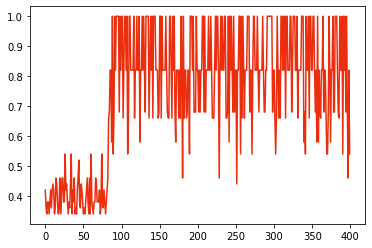

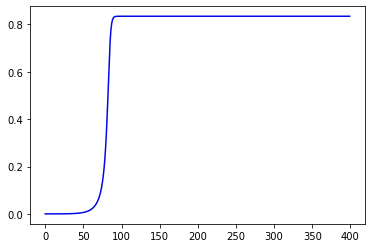

temp =  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


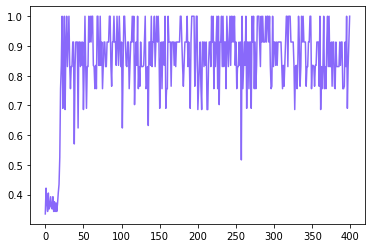

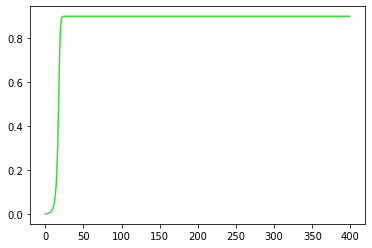

temp =  4


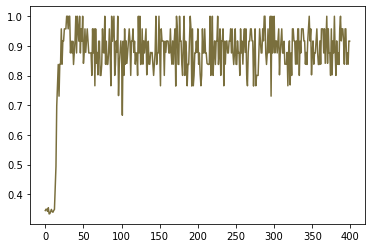

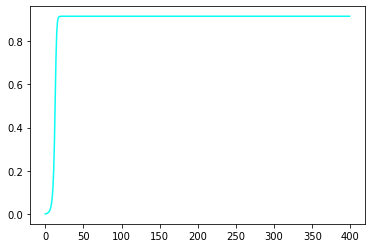

temp =  5


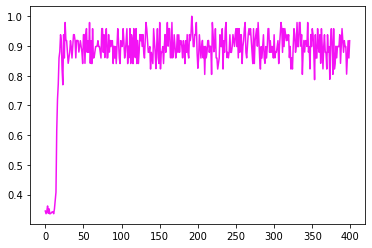

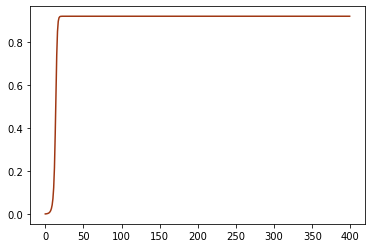

temp =  6


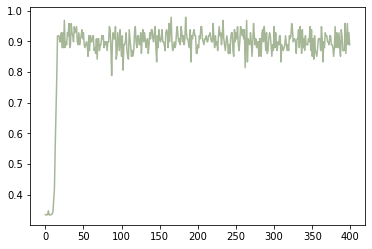

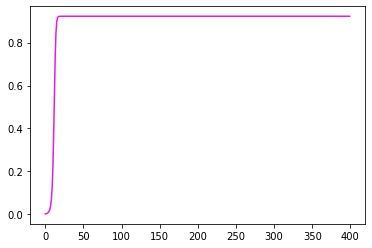

temp =  7


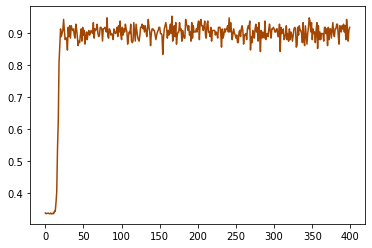

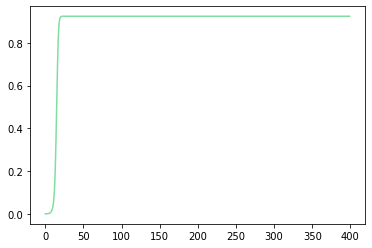

temp =  8


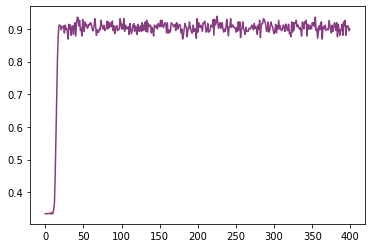

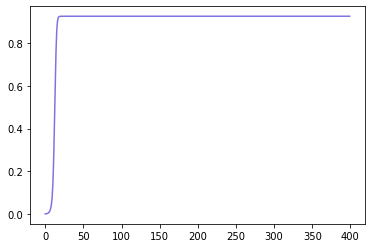

temp =  9


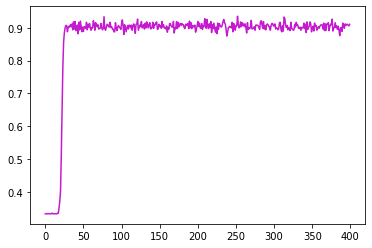

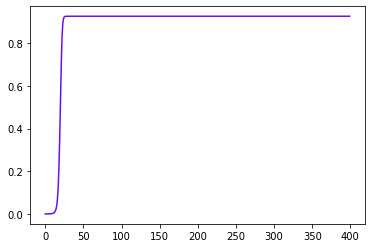

temp =  10


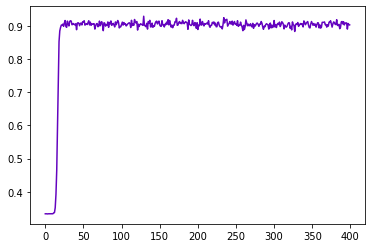

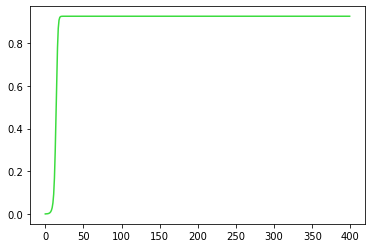

temp =  11


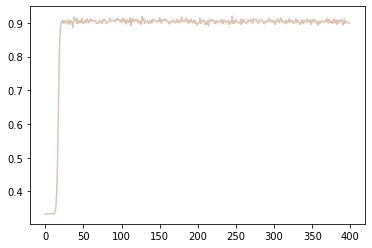

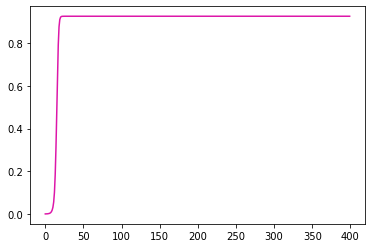

In [ ]:
t_mass = []
h_mass = []
h_mass_full = []
t_mass_full = []
for j in circ:
  print('temp = ', j)
  graph = graphs(parameters = [j, 3, 2], type_of = 'bethe_closure', iteration = True)
  model = potts(graph = graph, J = 0.1, gamma = 0.09, Q = 3, t = 400, synch = True)
  result = model.evol()
  t_mass.append(result[1][-1][0])
  h_mass.append(np.mean(result[0][-50:-1], axis = 0))
  h_mass_full.append(np.mean(result[2][-50:-1]))
  t_mass_full.append(np.mean(result[3][-50:-1]))
  plotting_full(result[-2])
  plotting_full(result[3])

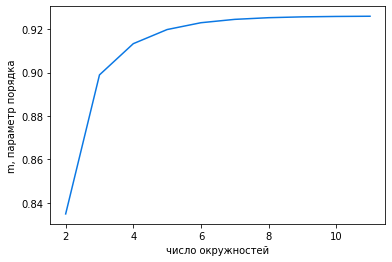

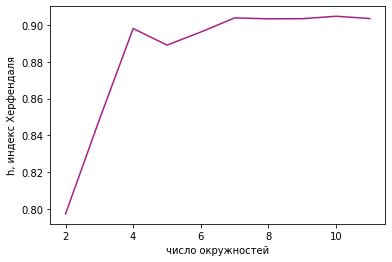

In [ ]:
#plotting(np.transpose(t_mass), circ, 'T, температура', 'm, параметр порядка')
#plotting(np.transpose(h_mass), circ, 'T, температура', 'h, индекс Херфендаля')
plotting_full_und(t_mass_full, circ, 'число окружностей', 'm, параметр порядка')
plotting_full_und(h_mass_full, circ, 'число окружностей', 'h, индекс Херфендаля',)

In [ ]:
1/(4*np.log(2))

0.36067376022224085

In [ ]:
vector_mass = [[0,1], [(3**(0.5))/2, -0.5], [-(3**(0.5))/2, -0.5]] #for Q = 3 use fslove
vector_mass

AttributeError: ignored

In [ ]:
def function(X):
  Y = []
  for ind in range(len(X))
  Y[ind] = X[ind]